# IMPORT


In [105]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [106]:
import requests
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, avg
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import split
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(rc={'figure.figsize':(8,8)})

In [108]:
!wget -O car.csv "https://raw.githubusercontent.com/Tran-Tho-69/Car_price_prediction-/refs/heads/main/CarPrice_Assignment.csv"
!ls -l car.csv


--2025-02-13 14:28:13--  https://raw.githubusercontent.com/Tran-Tho-69/Car_price_prediction-/refs/heads/main/CarPrice_Assignment.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26511 (26K) [text/plain]
Saving to: ‘car.csv’

car.csv             100%[===================>]  25.89K  --.-KB/s    in 0.002s  

2025-02-13 14:28:13 (13.3 MB/s) - ‘car.csv’ saved [26511/26511]

-rw-r--r-- 1 root root 26511 Feb 13 14:28 car.csv


In [109]:
df = pd.read_csv("car.csv")
df.head(5)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [110]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("CarRegression").getOrCreate()

In [111]:
spark = SparkSession.builder.appName("CarRegression").config("spark.executor.memory", "4g").config("spark.driver.memory","2g").getOrCreate()

In [112]:
# đọc dữ liệu từ csv vào spark dataframe
df = spark.createDataFrame(df)
# hiển thị 5 dòng đầu tiên
df.show(5)

+------+---------+--------------------+--------+----------+----------+-----------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-------+
|car_ID|symboling|             CarName|fueltype|aspiration|doornumber|    carbody|drivewheel|enginelocation|wheelbase|carlength|carwidth|carheight|curbweight|enginetype|cylindernumber|enginesize|fuelsystem|boreratio|stroke|compressionratio|horsepower|peakrpm|citympg|highwaympg|  price|
+------+---------+--------------------+--------+----------+----------+-----------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-------+
|     1|        3|  alfa-romero giulia|     gas|       std|       two|convertible|       rwd|         front|     88.6|    168.8|    64.1|  

In [113]:
df.printSchema()

root
 |-- car_ID: long (nullable = true)
 |-- symboling: long (nullable = true)
 |-- CarName: string (nullable = true)
 |-- fueltype: string (nullable = true)
 |-- aspiration: string (nullable = true)
 |-- doornumber: string (nullable = true)
 |-- carbody: string (nullable = true)
 |-- drivewheel: string (nullable = true)
 |-- enginelocation: string (nullable = true)
 |-- wheelbase: double (nullable = true)
 |-- carlength: double (nullable = true)
 |-- carwidth: double (nullable = true)
 |-- carheight: double (nullable = true)
 |-- curbweight: long (nullable = true)
 |-- enginetype: string (nullable = true)
 |-- cylindernumber: string (nullable = true)
 |-- enginesize: long (nullable = true)
 |-- fuelsystem: string (nullable = true)
 |-- boreratio: double (nullable = true)
 |-- stroke: double (nullable = true)
 |-- compressionratio: double (nullable = true)
 |-- horsepower: long (nullable = true)
 |-- peakrpm: long (nullable = true)
 |-- citympg: long (nullable = true)
 |-- highwaympg:

# Data Overview

In [114]:
# check data type
df.printSchema()

root
 |-- car_ID: long (nullable = true)
 |-- symboling: long (nullable = true)
 |-- CarName: string (nullable = true)
 |-- fueltype: string (nullable = true)
 |-- aspiration: string (nullable = true)
 |-- doornumber: string (nullable = true)
 |-- carbody: string (nullable = true)
 |-- drivewheel: string (nullable = true)
 |-- enginelocation: string (nullable = true)
 |-- wheelbase: double (nullable = true)
 |-- carlength: double (nullable = true)
 |-- carwidth: double (nullable = true)
 |-- carheight: double (nullable = true)
 |-- curbweight: long (nullable = true)
 |-- enginetype: string (nullable = true)
 |-- cylindernumber: string (nullable = true)
 |-- enginesize: long (nullable = true)
 |-- fuelsystem: string (nullable = true)
 |-- boreratio: double (nullable = true)
 |-- stroke: double (nullable = true)
 |-- compressionratio: double (nullable = true)
 |-- horsepower: long (nullable = true)
 |-- peakrpm: long (nullable = true)
 |-- citympg: long (nullable = true)
 |-- highwaympg:

In [115]:
from pyspark.sql.functions import col, sum

# Đếm số lượng giá trị null trong mỗi cột
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------+---------+-------+--------+----------+----------+-------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-----+
|car_ID|symboling|CarName|fueltype|aspiration|doornumber|carbody|drivewheel|enginelocation|wheelbase|carlength|carwidth|carheight|curbweight|enginetype|cylindernumber|enginesize|fuelsystem|boreratio|stroke|compressionratio|horsepower|peakrpm|citympg|highwaympg|price|
+------+---------+-------+--------+----------+----------+-------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-----+
|     0|        0|      0|       0|         0|         0|      0|         0|             0|        0|        0|       0|        0|         0|         0|             0|         0|         0|       

In [116]:
# Tạo dictionary chứa số lượng giá trị duy nhất cho mỗi cột
unique_counts = {col: df.select(col).distinct().count() for col in df.columns}

# In ra số lượng giá trị duy nhất của từng cột
print(unique_counts)

{'car_ID': 205, 'symboling': 6, 'CarName': 147, 'fueltype': 2, 'aspiration': 2, 'doornumber': 2, 'carbody': 5, 'drivewheel': 3, 'enginelocation': 2, 'wheelbase': 53, 'carlength': 75, 'carwidth': 44, 'carheight': 49, 'curbweight': 171, 'enginetype': 7, 'cylindernumber': 7, 'enginesize': 44, 'fuelsystem': 8, 'boreratio': 38, 'stroke': 37, 'compressionratio': 32, 'horsepower': 59, 'peakrpm': 23, 'citympg': 29, 'highwaympg': 30, 'price': 189}


# DATA CLEANING


In [117]:
# kiểm tra và xử lý giá trị thiếu
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+------+---------+-------+--------+----------+----------+-------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-----+
|car_ID|symboling|CarName|fueltype|aspiration|doornumber|carbody|drivewheel|enginelocation|wheelbase|carlength|carwidth|carheight|curbweight|enginetype|cylindernumber|enginesize|fuelsystem|boreratio|stroke|compressionratio|horsepower|peakrpm|citympg|highwaympg|price|
+------+---------+-------+--------+----------+----------+-------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-----+
|     0|        0|      0|       0|         0|         0|      0|         0|             0|        0|        0|       0|        0|         0|         0|             0|         0|         0|       

In [118]:
# trích xuất hãng xe từ tên xe
df = df.withColumn("CarName", split(df["CarName"], " ").getItem(0))
df = df.withColumn("CarName", split(df["CarName"], "-").getItem(0))

In [119]:
df.show(5)

+------+---------+-------+--------+----------+----------+-----------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-------+
|car_ID|symboling|CarName|fueltype|aspiration|doornumber|    carbody|drivewheel|enginelocation|wheelbase|carlength|carwidth|carheight|curbweight|enginetype|cylindernumber|enginesize|fuelsystem|boreratio|stroke|compressionratio|horsepower|peakrpm|citympg|highwaympg|  price|
+------+---------+-------+--------+----------+----------+-----------+----------+--------------+---------+---------+--------+---------+----------+----------+--------------+----------+----------+---------+------+----------------+----------+-------+-------+----------+-------+
|     1|        3|   alfa|     gas|       std|       two|convertible|       rwd|         front|     88.6|    168.8|    64.1|     48.8|      2548|      dohc|          four|       

In [120]:
from pyspark.sql.functions import regexp_replace

# Giả sử df là DataFrame trong PySpark
df = df.withColumn("CarName",
                   regexp_replace(df["CarName"], "maxda", "mazda"))
df = df.withColumn("CarName",
                   regexp_replace(df["CarName"], "nissan", "Nissan"))
df = df.withColumn("CarName",
                   regexp_replace(df["CarName"], "porcshce", "porsche"))
df = df.withColumn("CarName",
                   regexp_replace(df["CarName"], "toyouta", "toyota"))
df = df.withColumn("CarName",
                   regexp_replace(df["CarName"], "vokswagen", "volkswagen"))
df = df.withColumn("CarName",
                   regexp_replace(df["CarName"], "vw", "volkswagen"))

In [121]:
from pyspark.sql.functions import col

# đổi kiểu dữ liệu cột symboling
df = df.withColumn("symboling", col("symboling").cast("string"))

In [122]:
from pyspark.sql import functions as F

# Lấy danh sách các cột có kiểu dữ liệu 'string'
categorical_cols = [col for col, dtype in df.dtypes if dtype == 'string']

# Chọn các cột phân loại từ DataFrame
categorical_df = df.select(*categorical_cols)

# Hiển thị DataFrame kết quả
categorical_df.show()

+---------+---------+--------+----------+----------+-----------+----------+--------------+----------+--------------+----------+
|symboling|  CarName|fueltype|aspiration|doornumber|    carbody|drivewheel|enginelocation|enginetype|cylindernumber|fuelsystem|
+---------+---------+--------+----------+----------+-----------+----------+--------------+----------+--------------+----------+
|        3|     alfa|     gas|       std|       two|convertible|       rwd|         front|      dohc|          four|      mpfi|
|        3|     alfa|     gas|       std|       two|convertible|       rwd|         front|      dohc|          four|      mpfi|
|        1|     alfa|     gas|       std|       two|  hatchback|       rwd|         front|      ohcv|           six|      mpfi|
|        2|     audi|     gas|       std|      four|      sedan|       fwd|         front|       ohc|          four|      mpfi|
|        2|     audi|     gas|       std|      four|      sedan|       4wd|         front|       ohc|   

In [123]:
from pyspark.sql import functions as F

# Lấy danh sách các cột có kiểu dữ liệu số
numerical_cols = [col for col, dtype in df.dtypes if dtype in ('int', 'bigint', 'float', 'double')]

# Chọn các cột số từ DataFrame
numerical_df = df.select(*numerical_cols)

# Hiển thị DataFrame kết quả
numerical_df.show()

+------+---------+---------+--------+---------+----------+----------+---------+------+----------------+----------+-------+-------+----------+---------+
|car_ID|wheelbase|carlength|carwidth|carheight|curbweight|enginesize|boreratio|stroke|compressionratio|horsepower|peakrpm|citympg|highwaympg|    price|
+------+---------+---------+--------+---------+----------+----------+---------+------+----------------+----------+-------+-------+----------+---------+
|     1|     88.6|    168.8|    64.1|     48.8|      2548|       130|     3.47|  2.68|             9.0|       111|   5000|     21|        27|  13495.0|
|     2|     88.6|    168.8|    64.1|     48.8|      2548|       130|     3.47|  2.68|             9.0|       111|   5000|     21|        27|  16500.0|
|     3|     94.5|    171.2|    65.5|     52.4|      2823|       152|     2.68|  3.47|             9.0|       154|   5000|     19|        26|  16500.0|
|     4|     99.8|    176.6|    66.2|     54.3|      2337|       109|     3.19|   3.4|  

In [124]:
df_pd = df.toPandas()

# EDA


## 1.Univariate analysis

### 1.1 Overview of car companies

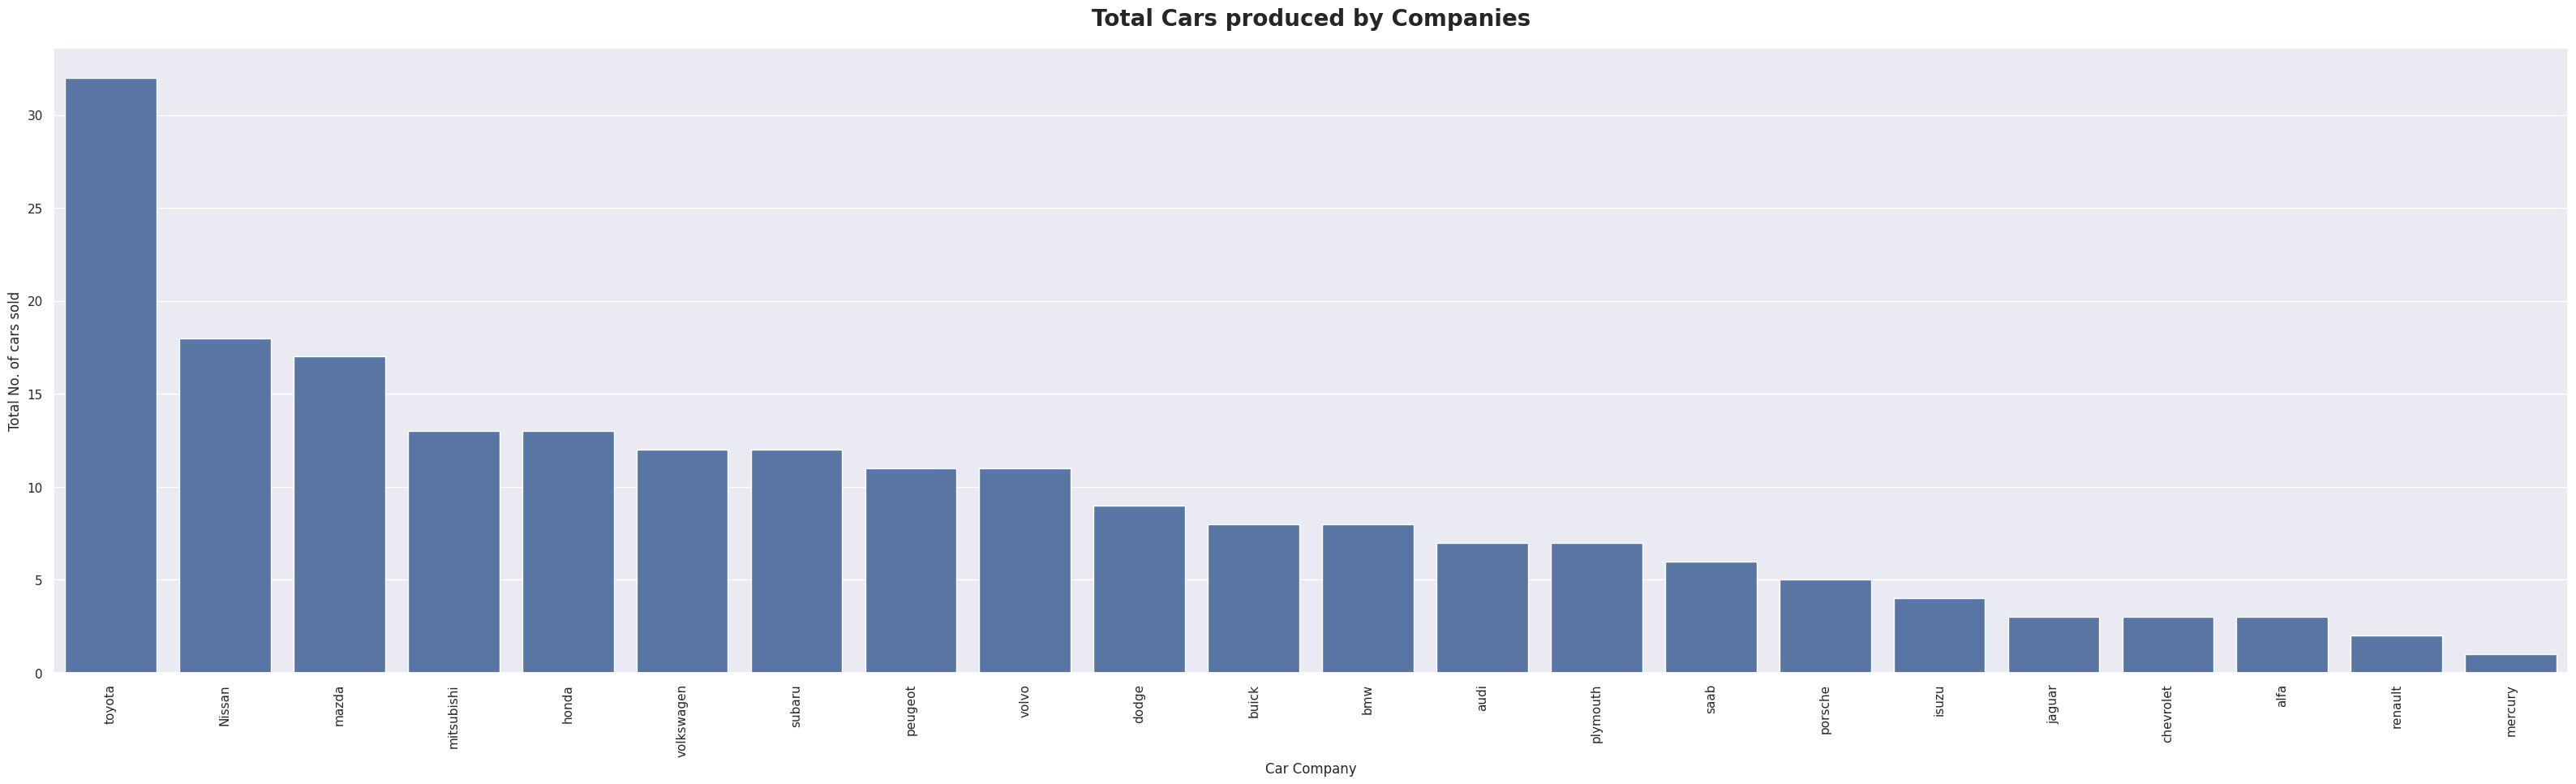

In [125]:
# Visualize the total number of car models sold by different companies
plt.figure(figsize=(40,10))
counts = df_pd["CarName"].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Car Company")
plt.ylabel("Total No. of cars sold")
plt.title("Total Cars produced by Companies", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

### 1.2 Overview of the Fuel type

+--------+-----+
|fueltype|count|
+--------+-----+
|     gas|  185|
|  diesel|   20|
+--------+-----+



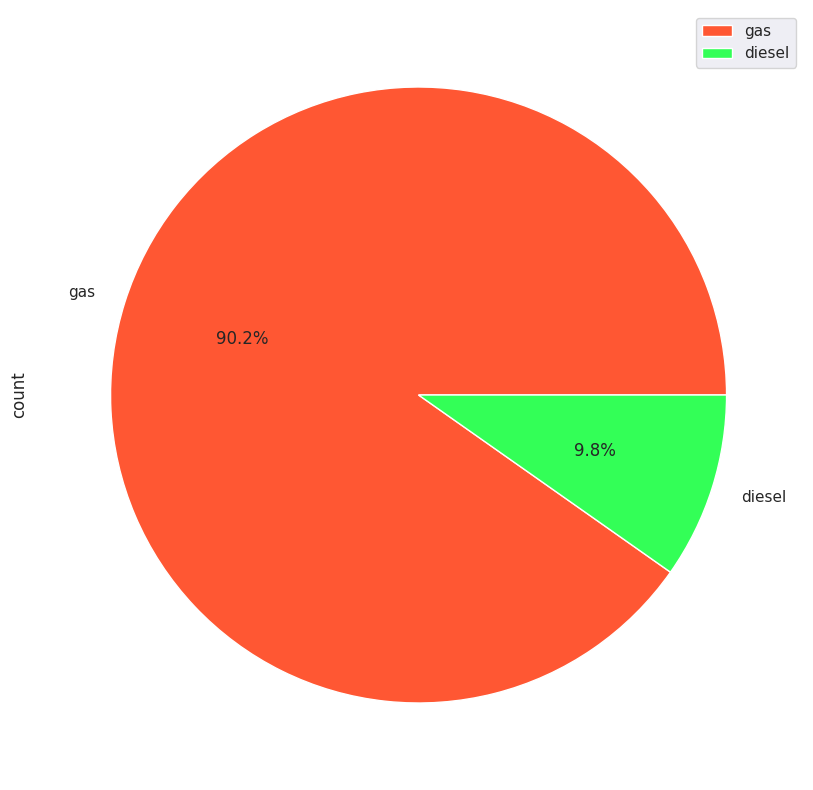

In [126]:
# Nhóm theo cột 'fueltype' và đếm số lần xuất hiện
df_count_fueltype= df.groupBy('fueltype').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_fueltype.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_fueltype = df_count_fueltype.toPandas()
df_pd_count_fueltype
plot = df_pd_count_fueltype.plot.pie(y='count', figsize=(10, 10), autopct='%1.1f%%', labels=df_pd_count_fueltype['fueltype'], colors=['#FF5733', '#33FF57'])


### 1.3 Overview of the aspiration

+----------+-----+
|aspiration|count|
+----------+-----+
|       std|  168|
|     turbo|   37|
+----------+-----+



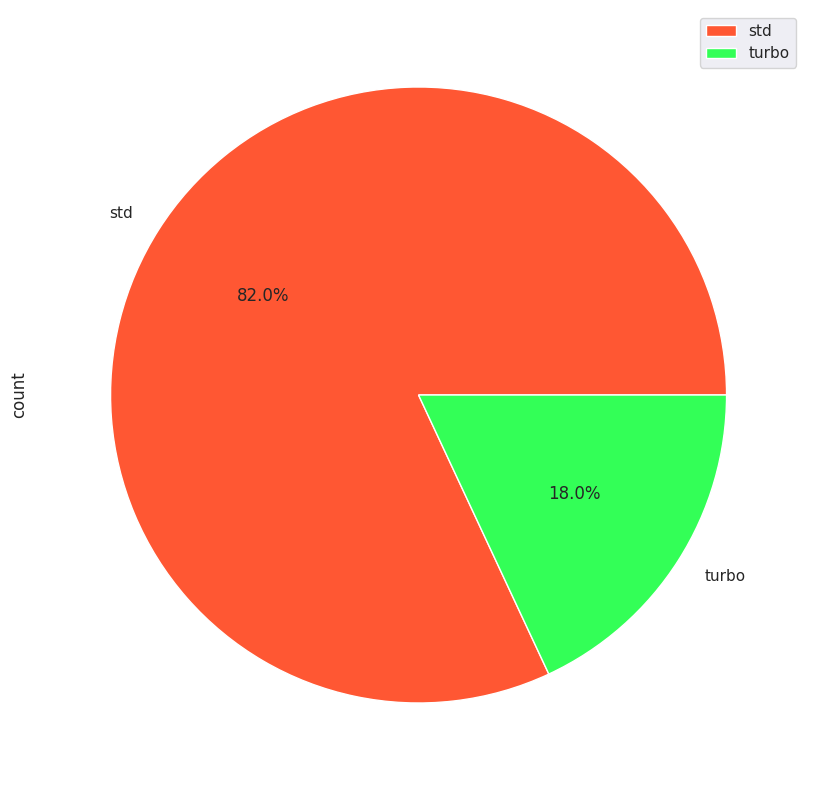

In [127]:
# Nhóm theo cột 'fueltype' và đếm số lần xuất hiện
df_count_aspiration= df.groupBy('aspiration').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_aspiration.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_aspiration = df_count_aspiration.toPandas()
df_pd_count_aspiration
plot = df_pd_count_aspiration.plot.pie(y='count', figsize=(10, 10), autopct='%1.1f%%', labels=df_pd_count_aspiration['aspiration'], colors=['#FF5733', '#33FF57'])


### 1.4 Overview of the body car

+-----------+-----+
|    carbody|count|
+-----------+-----+
|      wagon|   25|
|convertible|    6|
|      sedan|   96|
|  hatchback|   70|
|    hardtop|    8|
+-----------+-----+



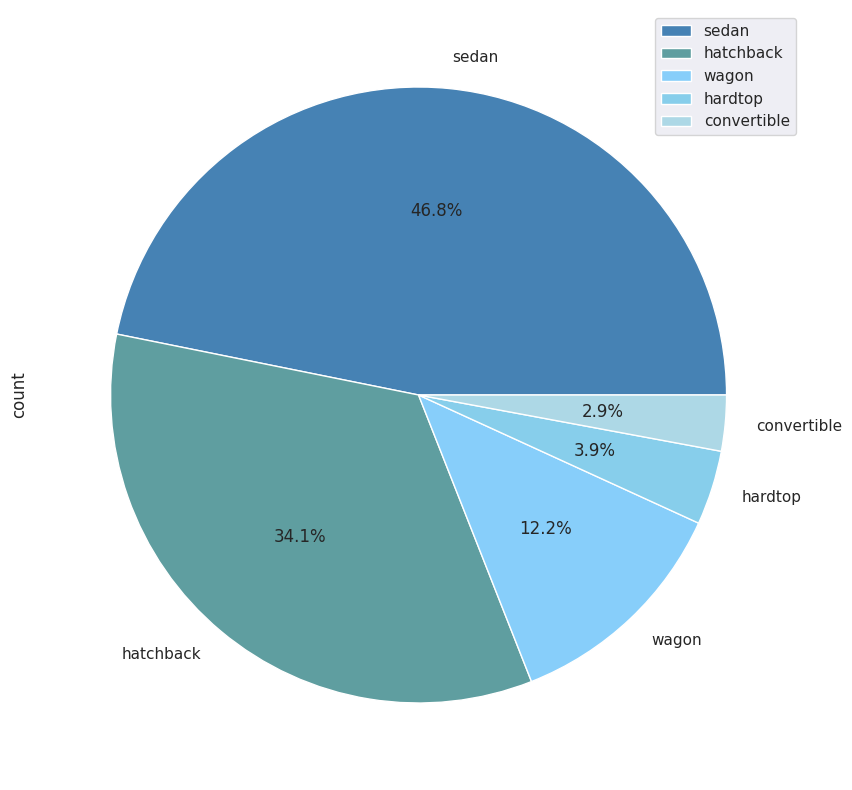

In [128]:
# Nhóm theo cột 'carbody' và đếm số lần xuất hiện
df_count_carbody= df.groupBy('carbody').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_carbody.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_carbody = df_count_carbody.toPandas()
df_pd_count_carbody = df_pd_count_carbody.sort_values(by='count', ascending=False)
df_pd_count_carbody
colors = ['#4682B4', '#5F9EA0', '#87CEFA', '#87CEEB', '#ADD8E6']
plot = df_pd_count_carbody.plot.pie(
    y='count',
    figsize=(10, 10),
    autopct='%1.1f%%',
    labels=df_pd_count_carbody['carbody'],
    colors=colors
)

### 1.5 Overview of the drive wheel

+----------+-----+
|drivewheel|count|
+----------+-----+
|       fwd|  120|
|       rwd|   76|
|       4wd|    9|
+----------+-----+



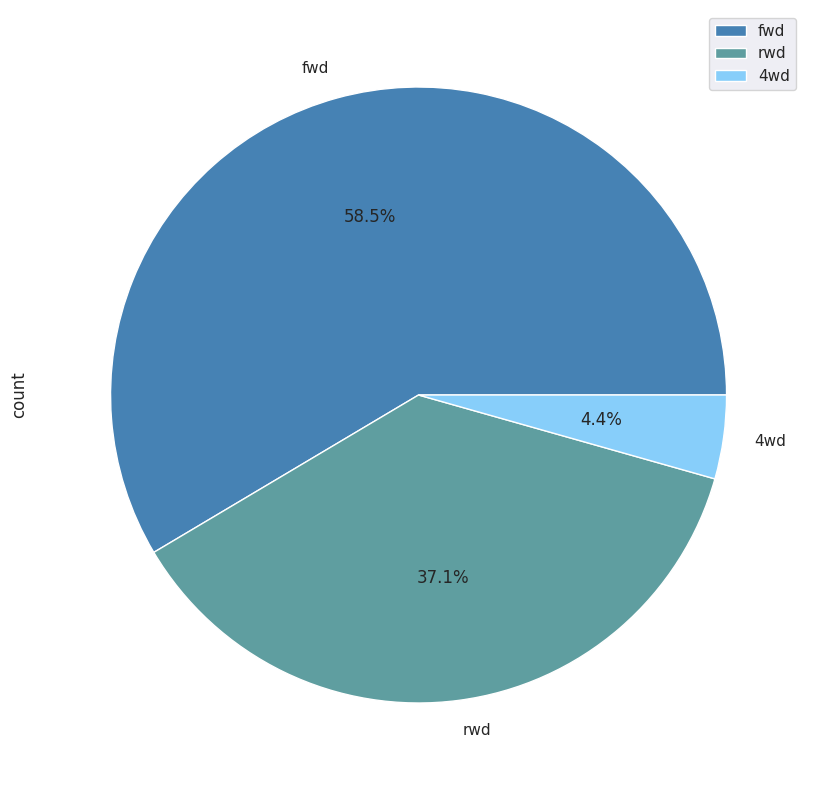

In [129]:
# Nhóm theo cột 'drivewheel' và đếm số lần xuất hiện
df_count_drivewheel= df.groupBy('drivewheel').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_drivewheel.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_drivewheel = df_count_drivewheel.toPandas()
df_pd_count_drivewheel
colors = ['#4682B4', '#5F9EA0', '#87CEFA', '#87CEEB', '#ADD8E6']
plot = df_pd_count_drivewheel.plot.pie(
    y='count',
    figsize=(10, 10),
    autopct='%1.1f%%',
    labels=df_pd_count_drivewheel['drivewheel'],
    colors=colors
)

### 1.6 Overview of the enginelocation

+--------------+-----+
|enginelocation|count|
+--------------+-----+
|         front|  202|
|          rear|    3|
+--------------+-----+



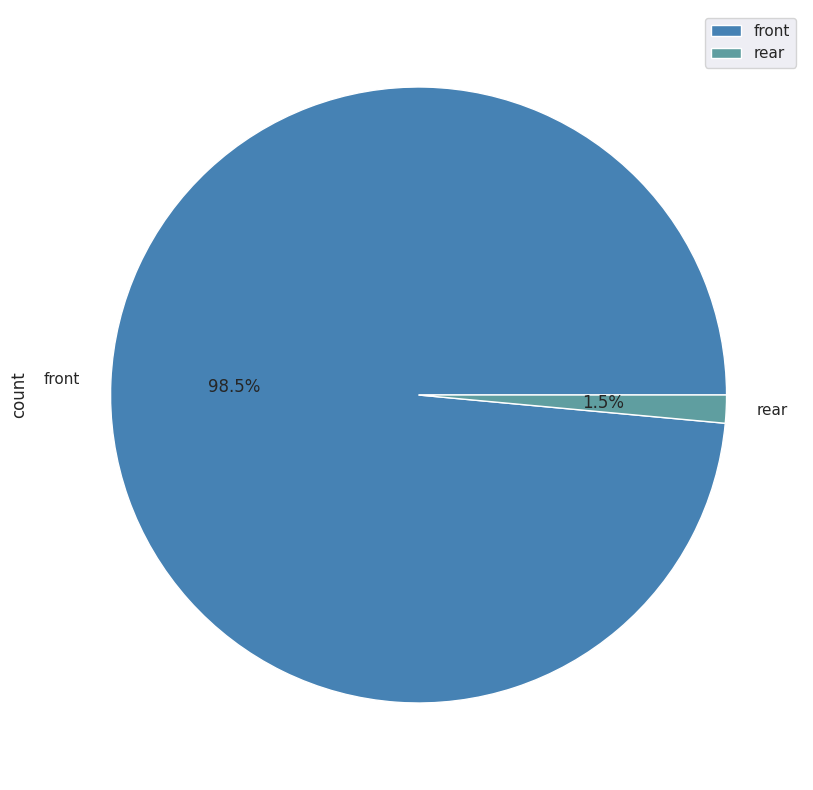

In [130]:
# Nhóm theo cột 'enginelocation' và đếm số lần xuất hiện
df_count_enginelocation= df.groupBy('enginelocation').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_enginelocation.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_enginelocation = df_count_enginelocation.toPandas()
df_pd_count_enginelocation
colors = ['#4682B4', '#5F9EA0', '#87CEFA', '#87CEEB', '#ADD8E6']
plot = df_pd_count_enginelocation.plot.pie(
    y='count',
    figsize=(10, 10),
    autopct='%1.1f%%',
    labels=df_pd_count_enginelocation['enginelocation'],
    colors=colors
)

In [131]:
df.describe().show()

+-------+-----------------+------------------+-------+--------+----------+----------+-----------+----------+--------------+-----------------+------------------+------------------+------------------+------------------+----------+--------------+------------------+----------+------------------+-------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|summary|           car_ID|         symboling|CarName|fueltype|aspiration|doornumber|    carbody|drivewheel|enginelocation|        wheelbase|         carlength|          carwidth|         carheight|        curbweight|enginetype|cylindernumber|        enginesize|fuelsystem|         boreratio|             stroke|  compressionratio|       horsepower|          peakrpm|          citympg|       highwaympg|             price|
+-------+-----------------+------------------+-------+--------+----------+----------+-----------+----------+--------------+-----------------+-------------

### 1.7 car price allocation

<Axes: xlabel='price', ylabel='Count'>

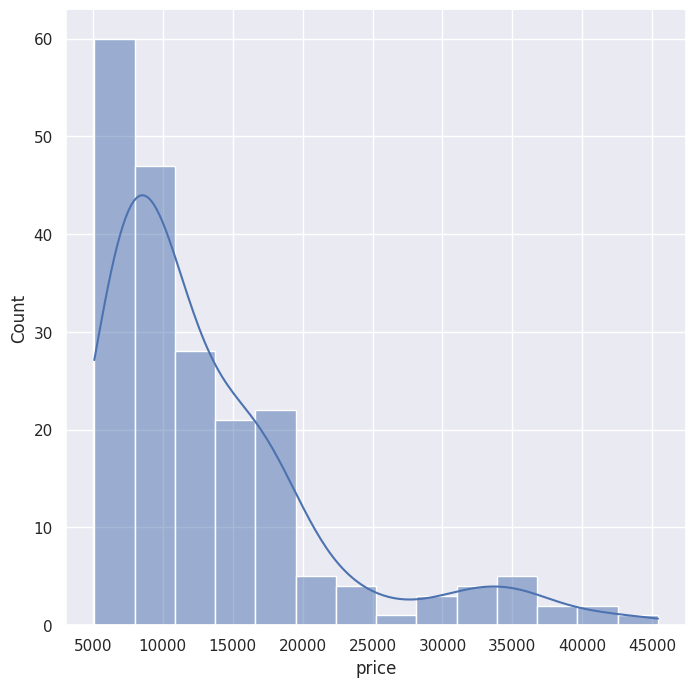

In [132]:
#sự phân bổ giá xe
sns.histplot(df_pd['price'],kde=True)

## 2.Multivariate analysis

### 2.1 Visualizing Car Company with Price

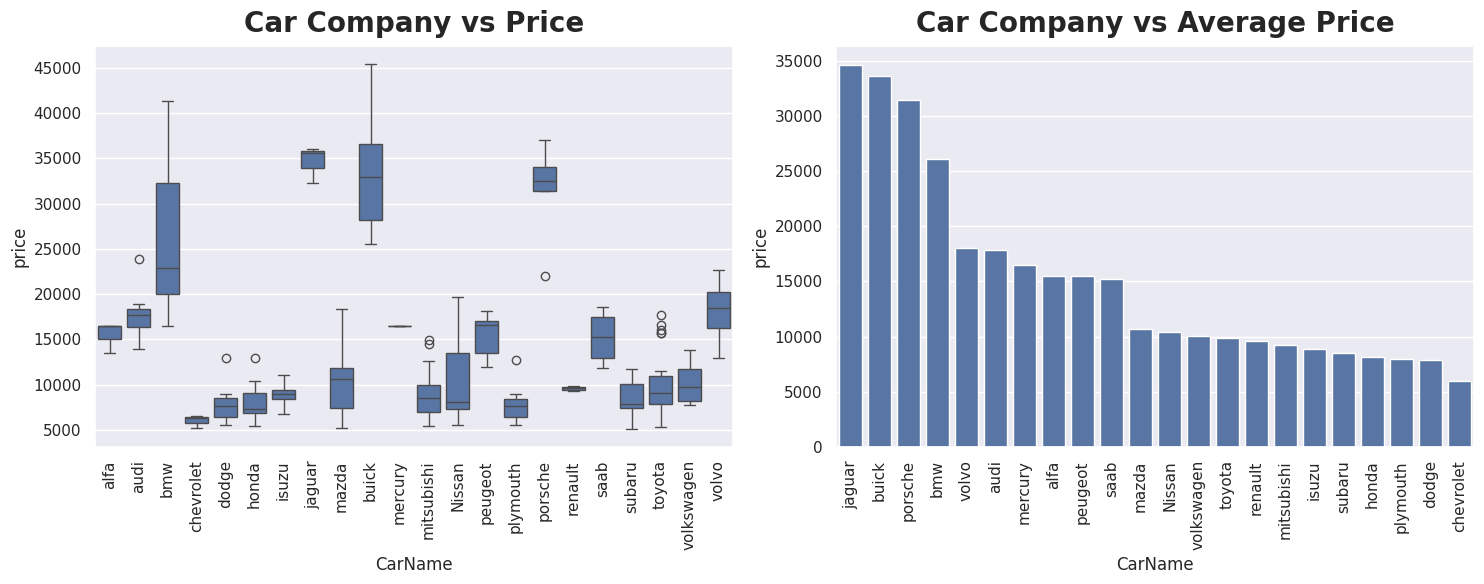

In [133]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.boxplot(x="CarName",y="price",data=df_pd)
plt.xticks(rotation=90)
plt.title("Car Company vs Price", pad=10, fontweight="black", fontsize=20)

plt.subplot(1,2,2)
x = pd.DataFrame(df_pd.groupby("CarName")["price"].mean().sort_values(ascending=False))
sns.barplot(x=x.index,y="price",data=x)
plt.xticks(rotation=90)
plt.title("Car Company vs Average Price", pad=10, fontweight="black", fontsize=20)
plt.tight_layout()
plt.show()

### 2.2 Visualizing Car Fuel Type Feature.

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


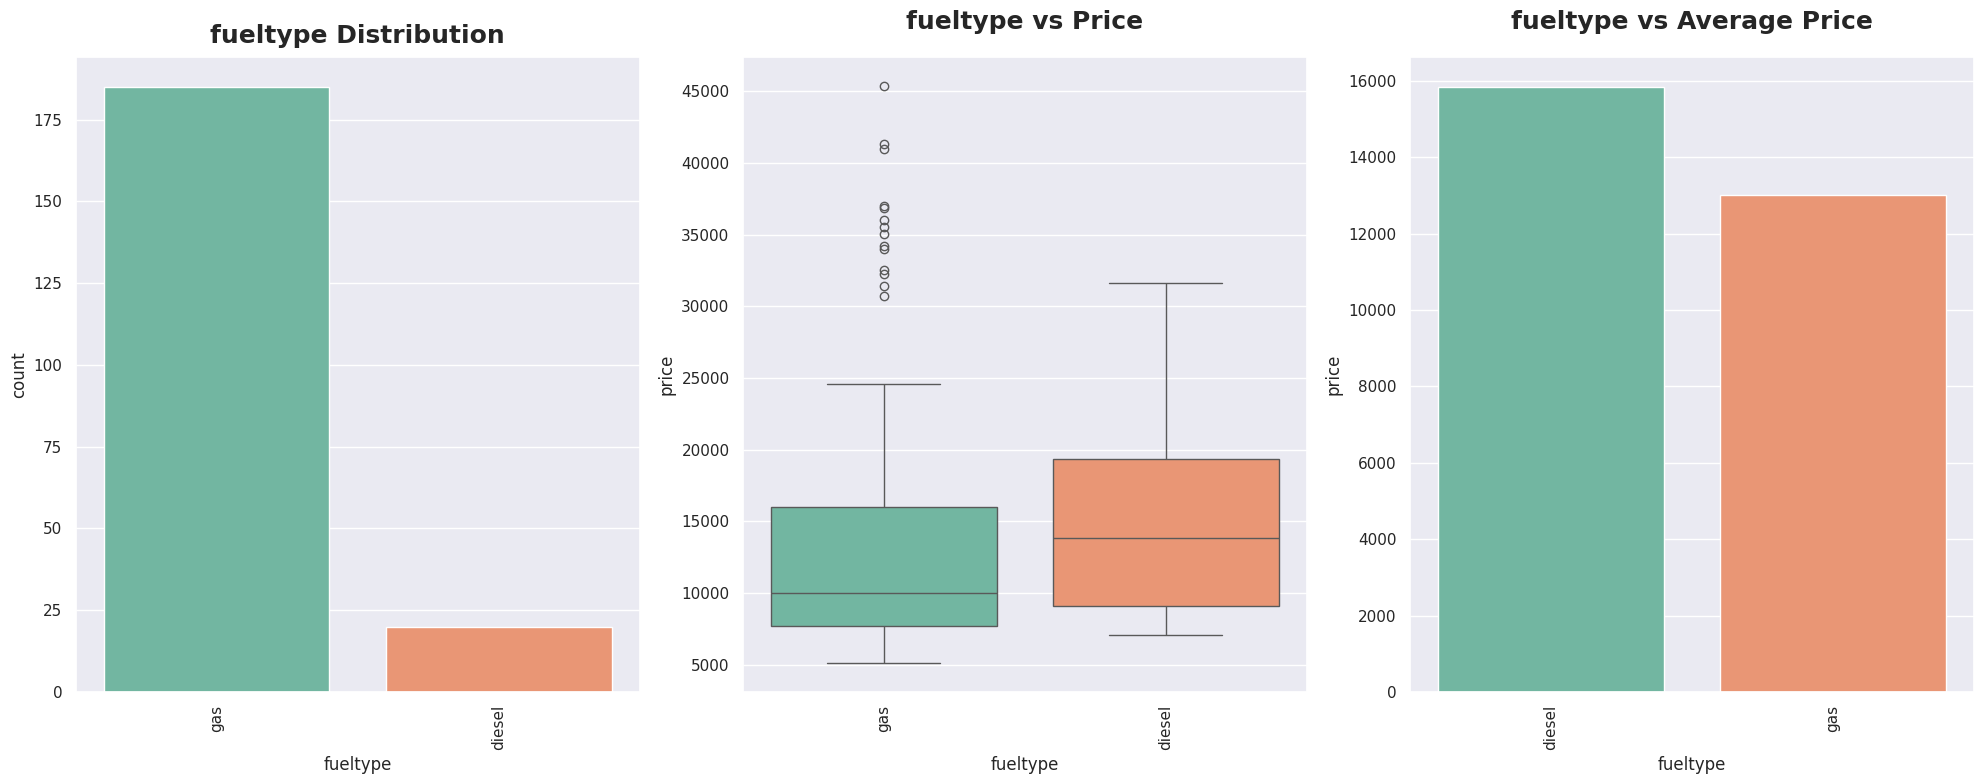

In [134]:
def categorical_visualization(cols):
    plt.figure(figsize=(20,8))

    # Biểu đồ countplot
    plt.subplot(1,3,1)
    sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
    plt.title(f"{cols} Distribution", pad=10, fontweight="black", fontsize=18)
    plt.xticks(rotation=90)

    # Biểu đồ boxplot
    plt.subplot(1,3,2)
    sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
    plt.title(f"{cols} vs Price", pad=20, fontweight="black", fontsize=18)
    plt.xticks(rotation=90)

    # Biểu đồ barplot
    plt.subplot(1,3,3)
    x = pd.DataFrame(df_pd.groupby(cols)["price"].mean().sort_values(ascending=False))
    sns.barplot(x=x.index, y="price", data=x, palette="Set2")
    plt.title(f"{cols} vs Average Price", pad=20, fontweight="black", fontsize=18)
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

# Gọi hàm
categorical_visualization("fueltype")


### 2.3 Visualizing Aspiration Feature

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


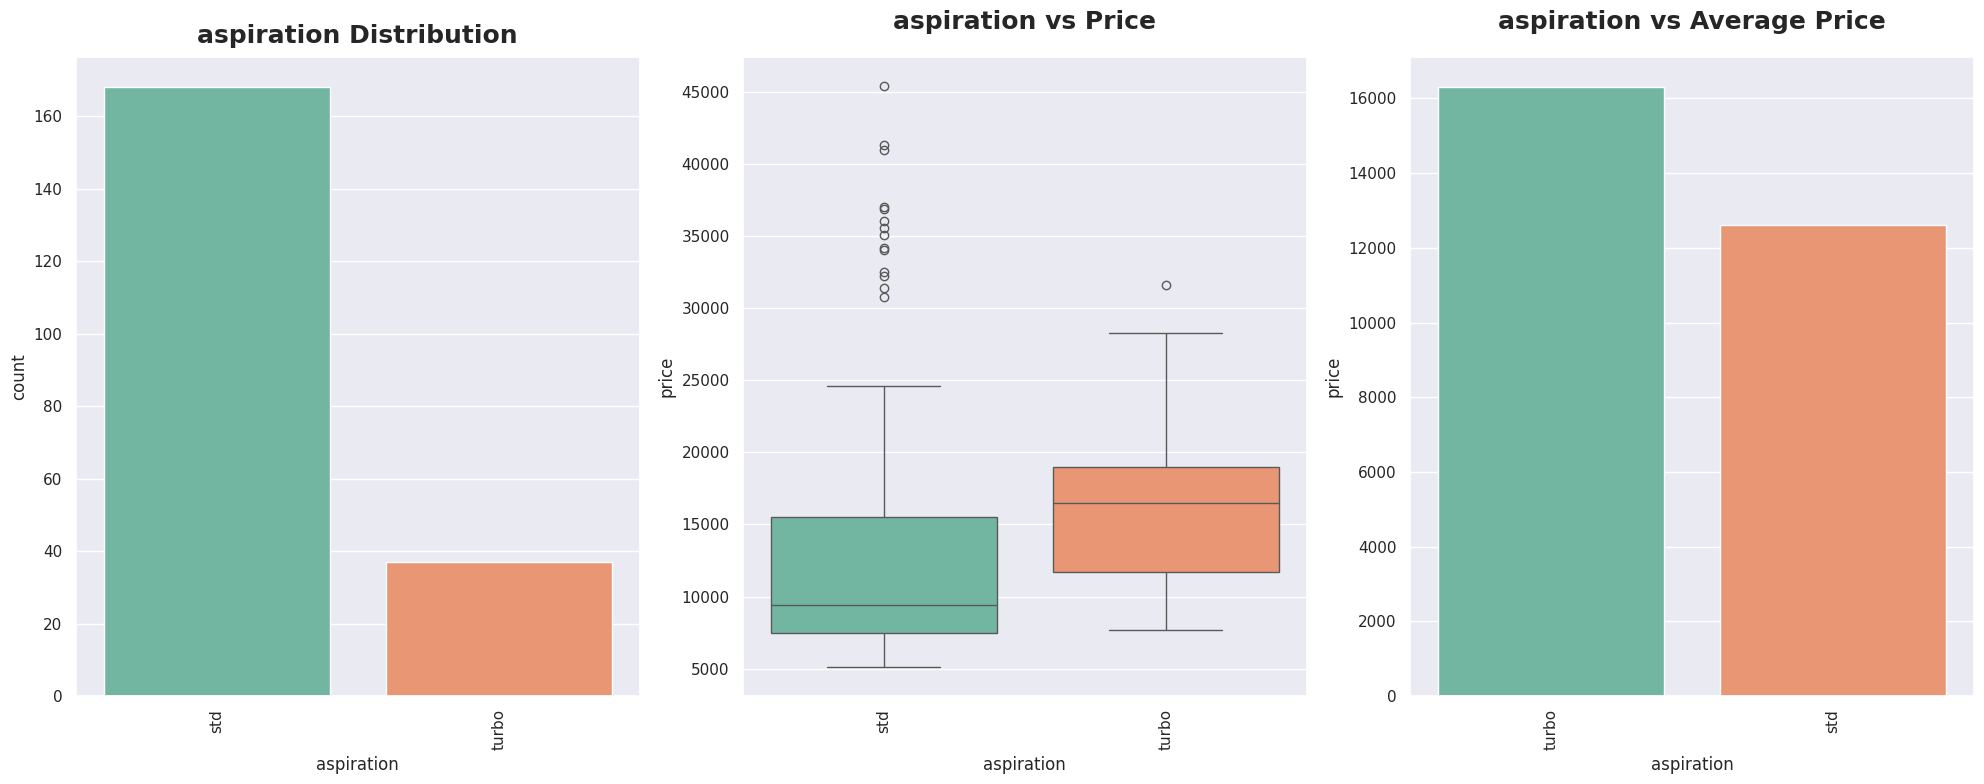

In [135]:
categorical_visualization("aspiration")

### 2.4 Visualizing Door Nubmer Feature

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


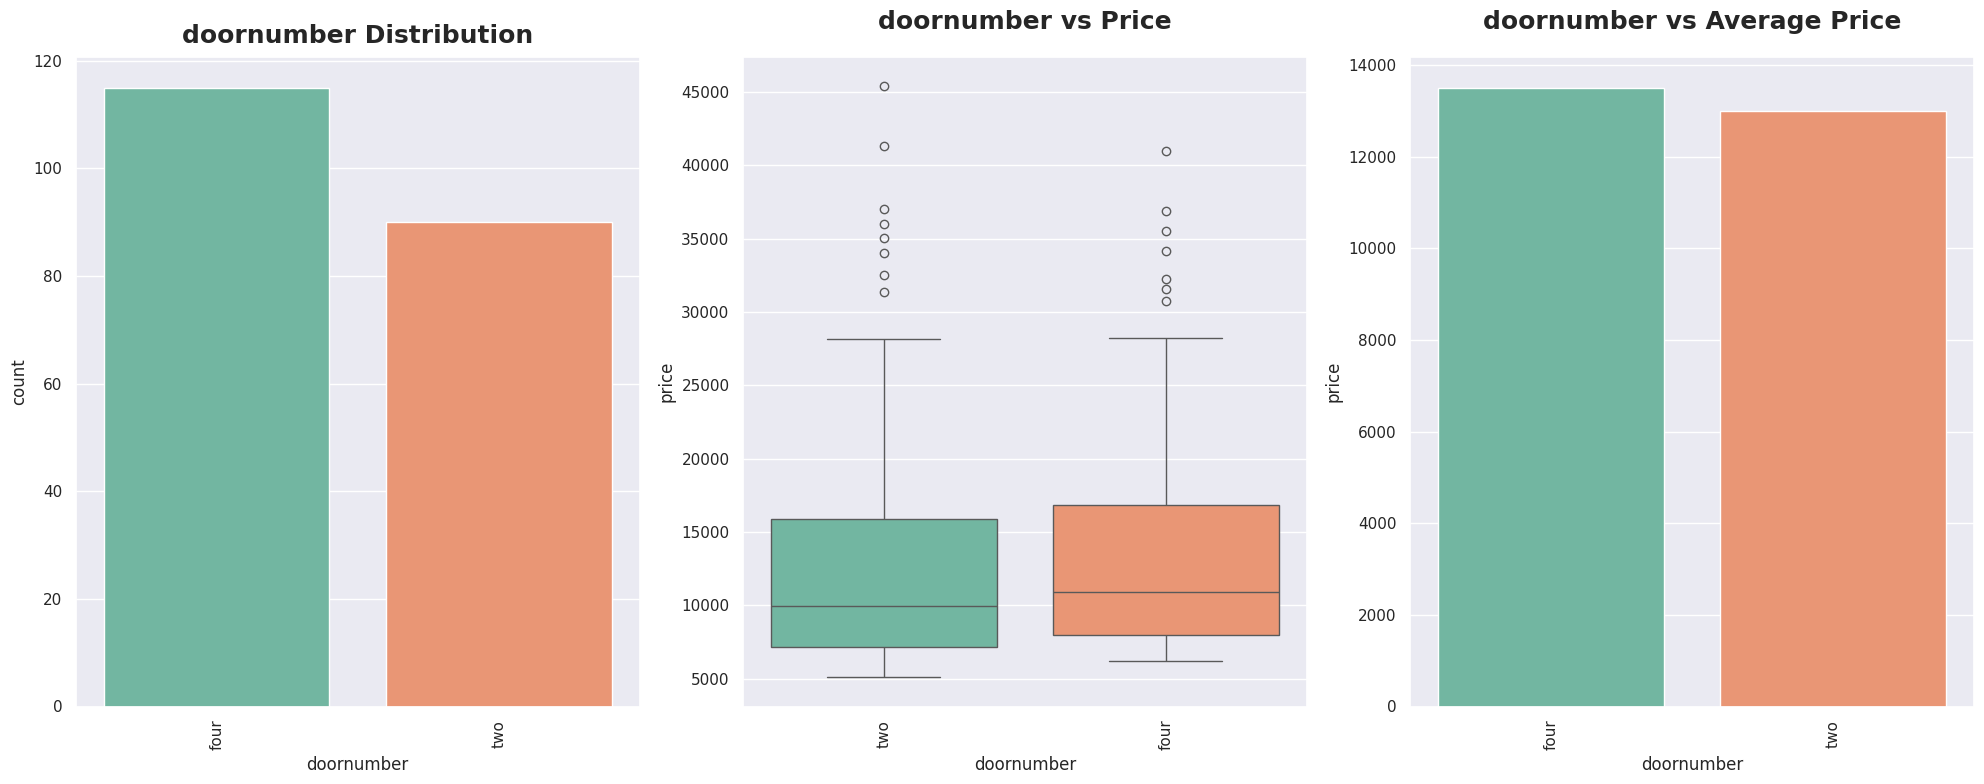

In [136]:
categorical_visualization("doornumber")

### 2.5 Visualizing Car Body Type Feature

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


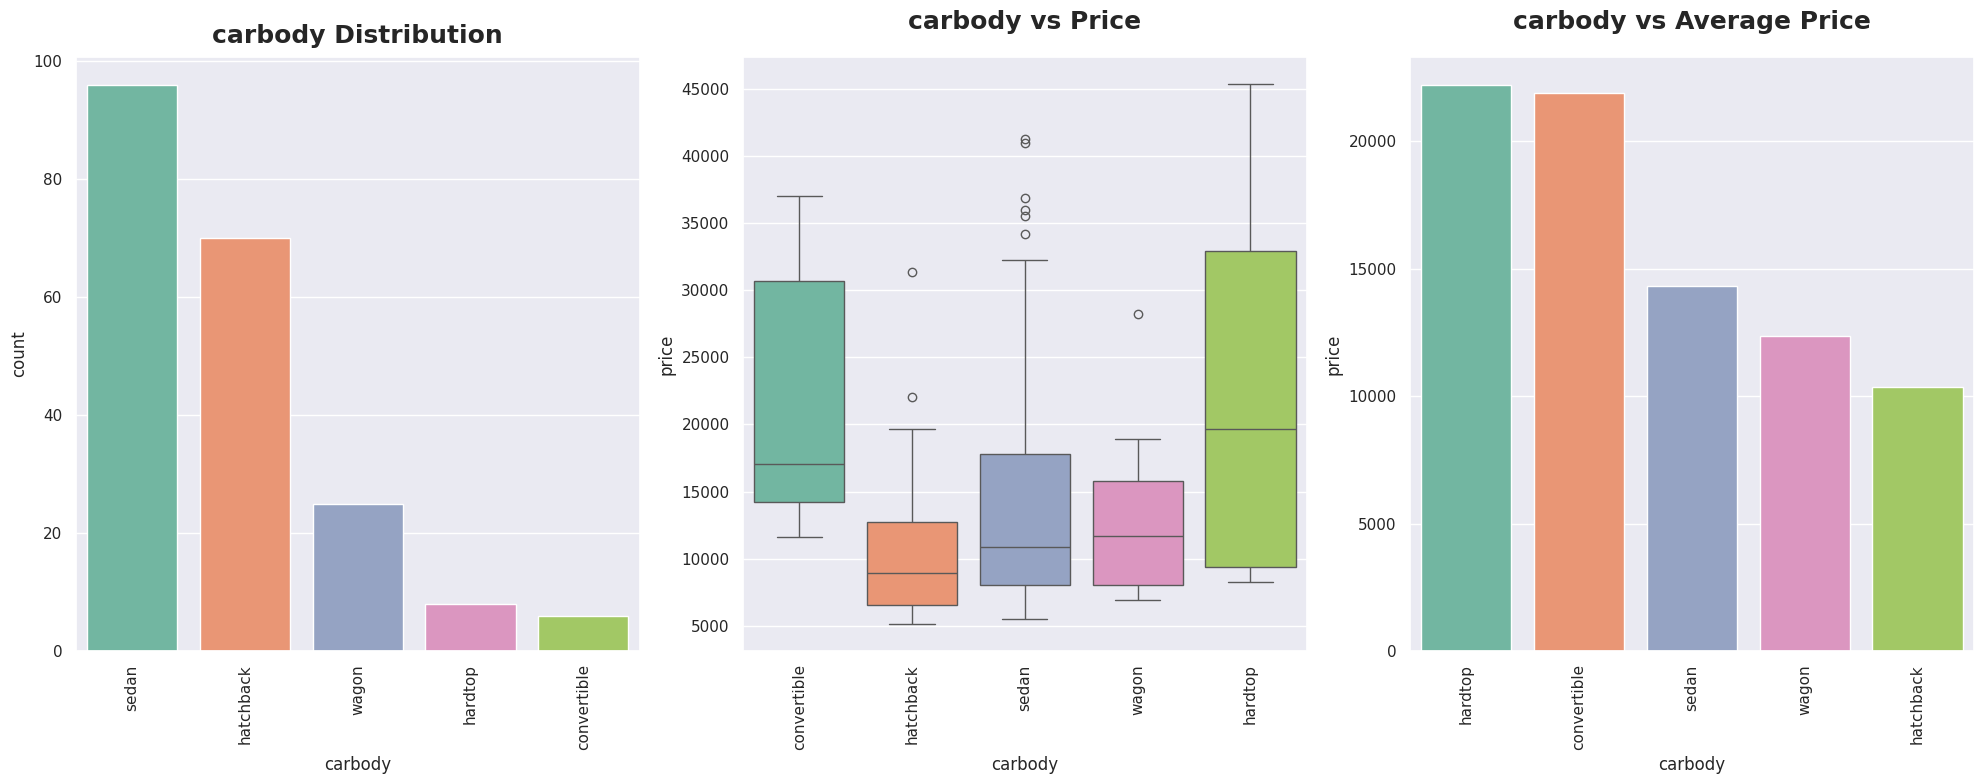

In [137]:
categorical_visualization("carbody")

### 2.6 Visualizing Drive Wheel Feature

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


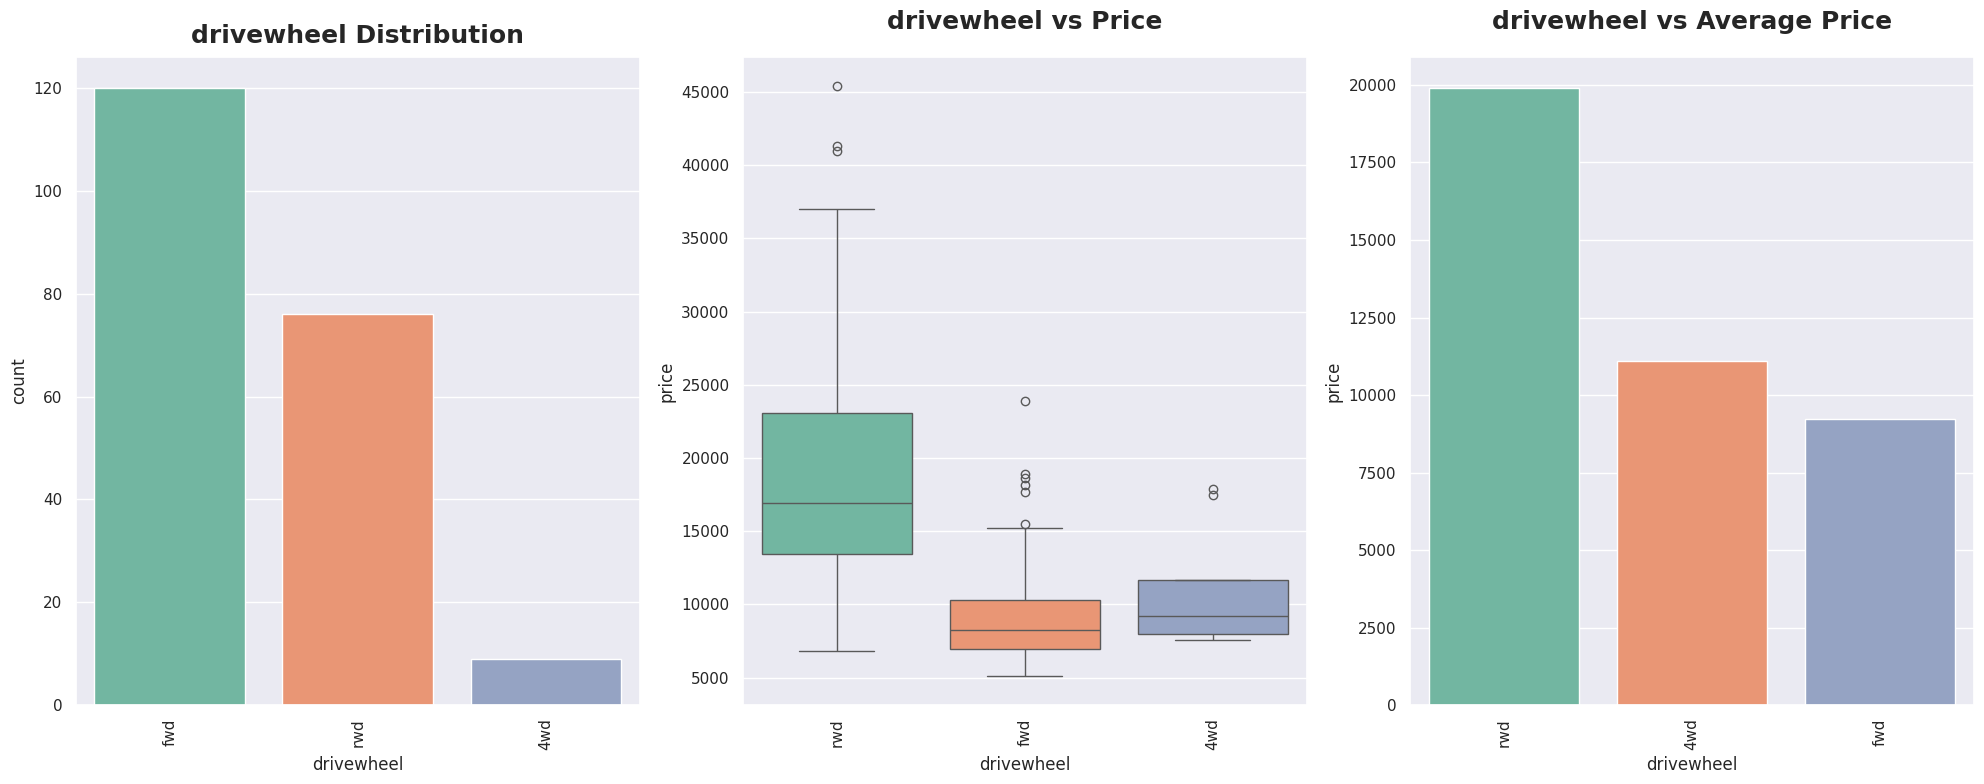

In [138]:
categorical_visualization("drivewheel")

### 2.7 Visualizing Engine Location Feature


<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


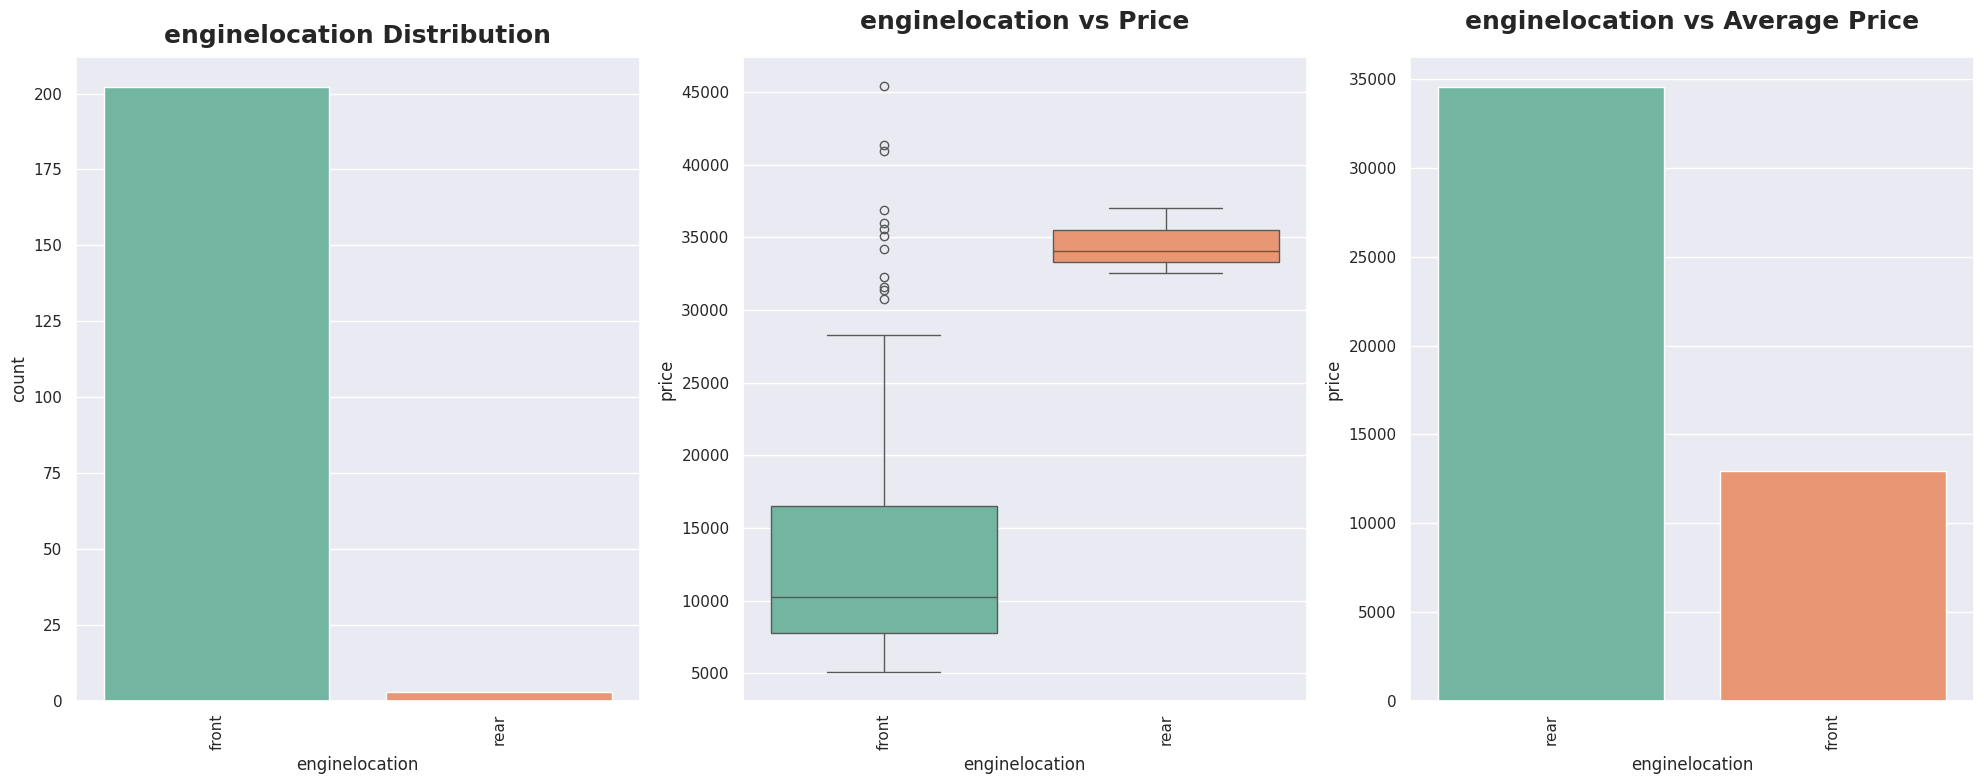

In [139]:
categorical_visualization("enginelocation")

### 2.8 Visualizing Engine Type Feature


<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


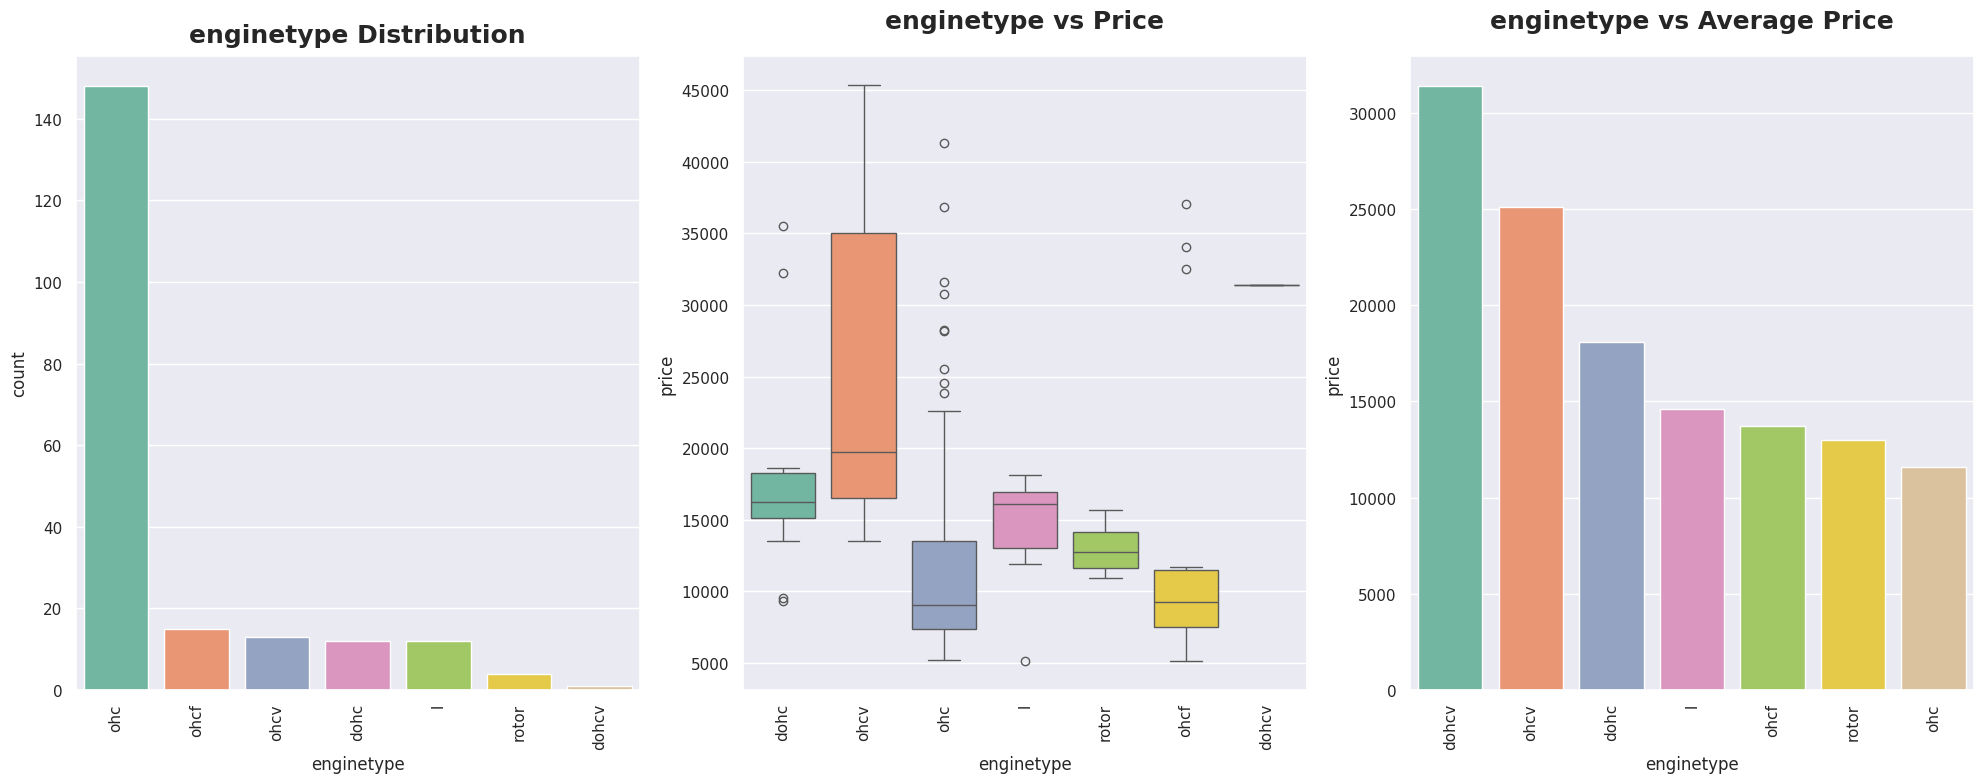

In [140]:
categorical_visualization("enginetype")

### 2.9 Visualizing Cyclinder Number Feature


<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


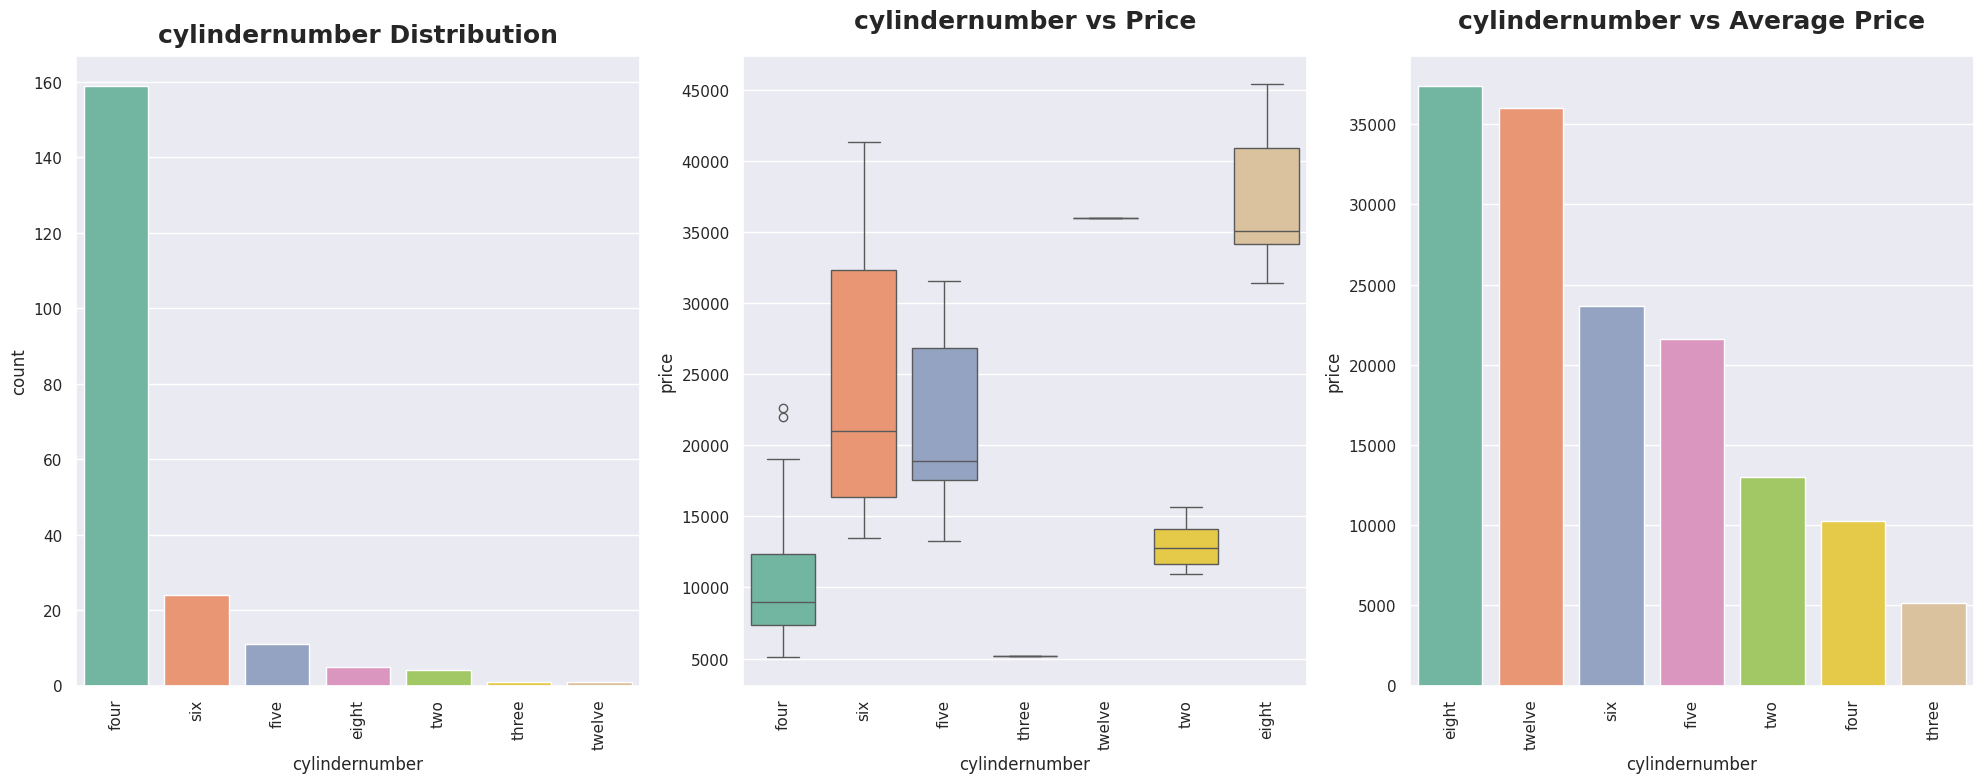

In [141]:
categorical_visualization("cylindernumber")

### 2.10 Visualizing Fuel System Feature

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


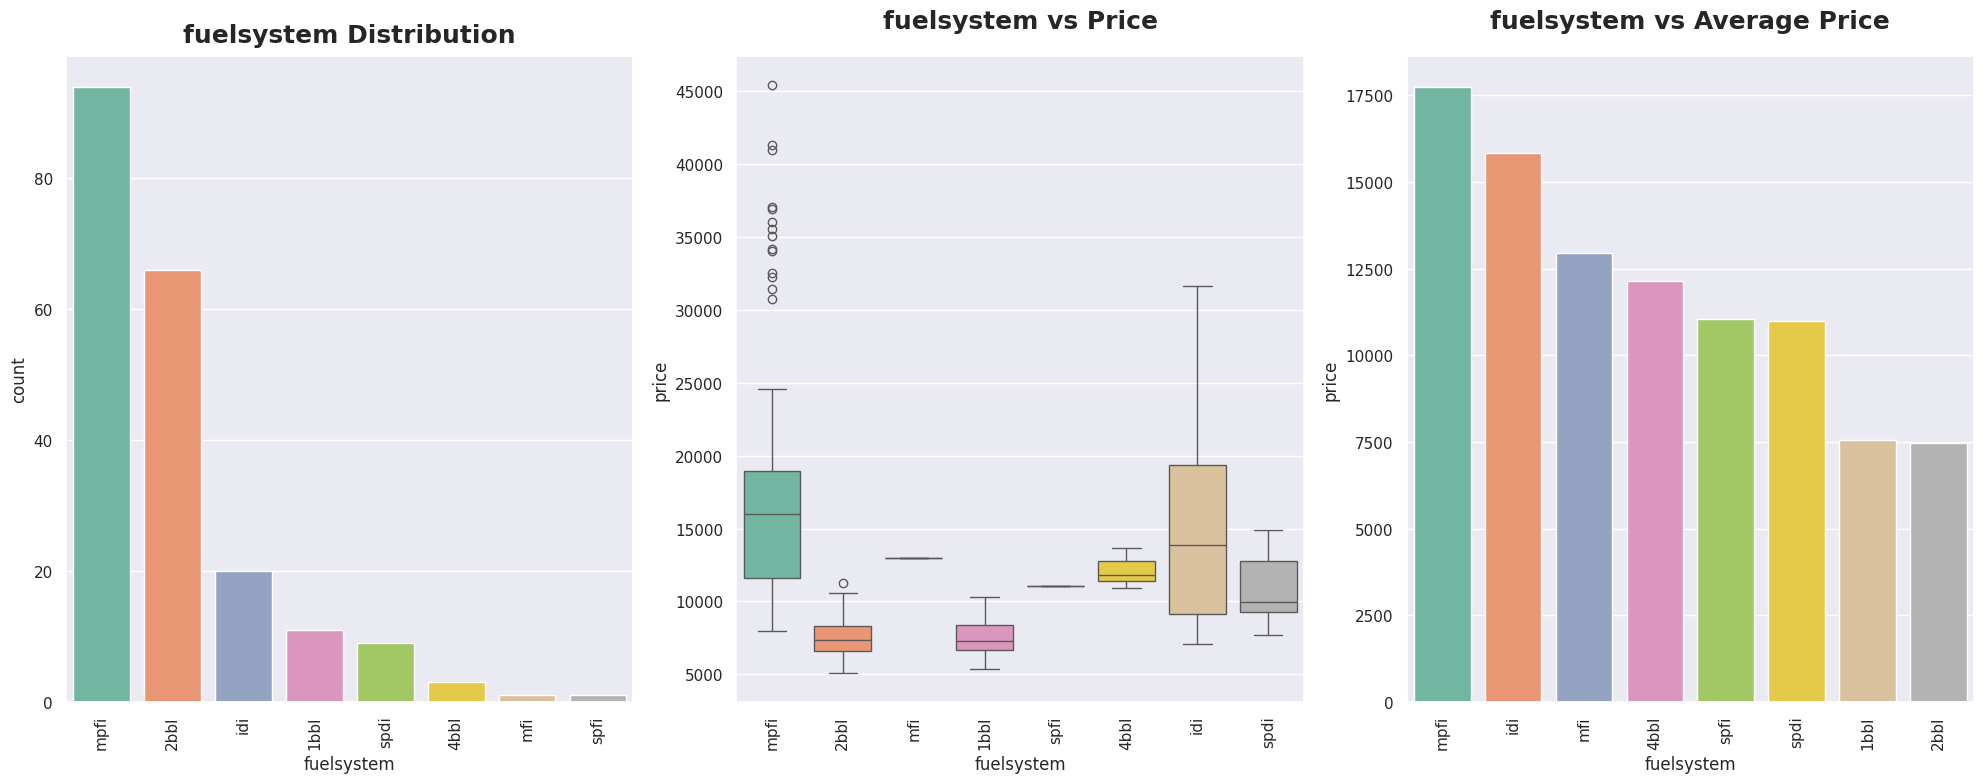

In [142]:
categorical_visualization("fuelsystem")

### 2.11 Visualizing Symboling Feature

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


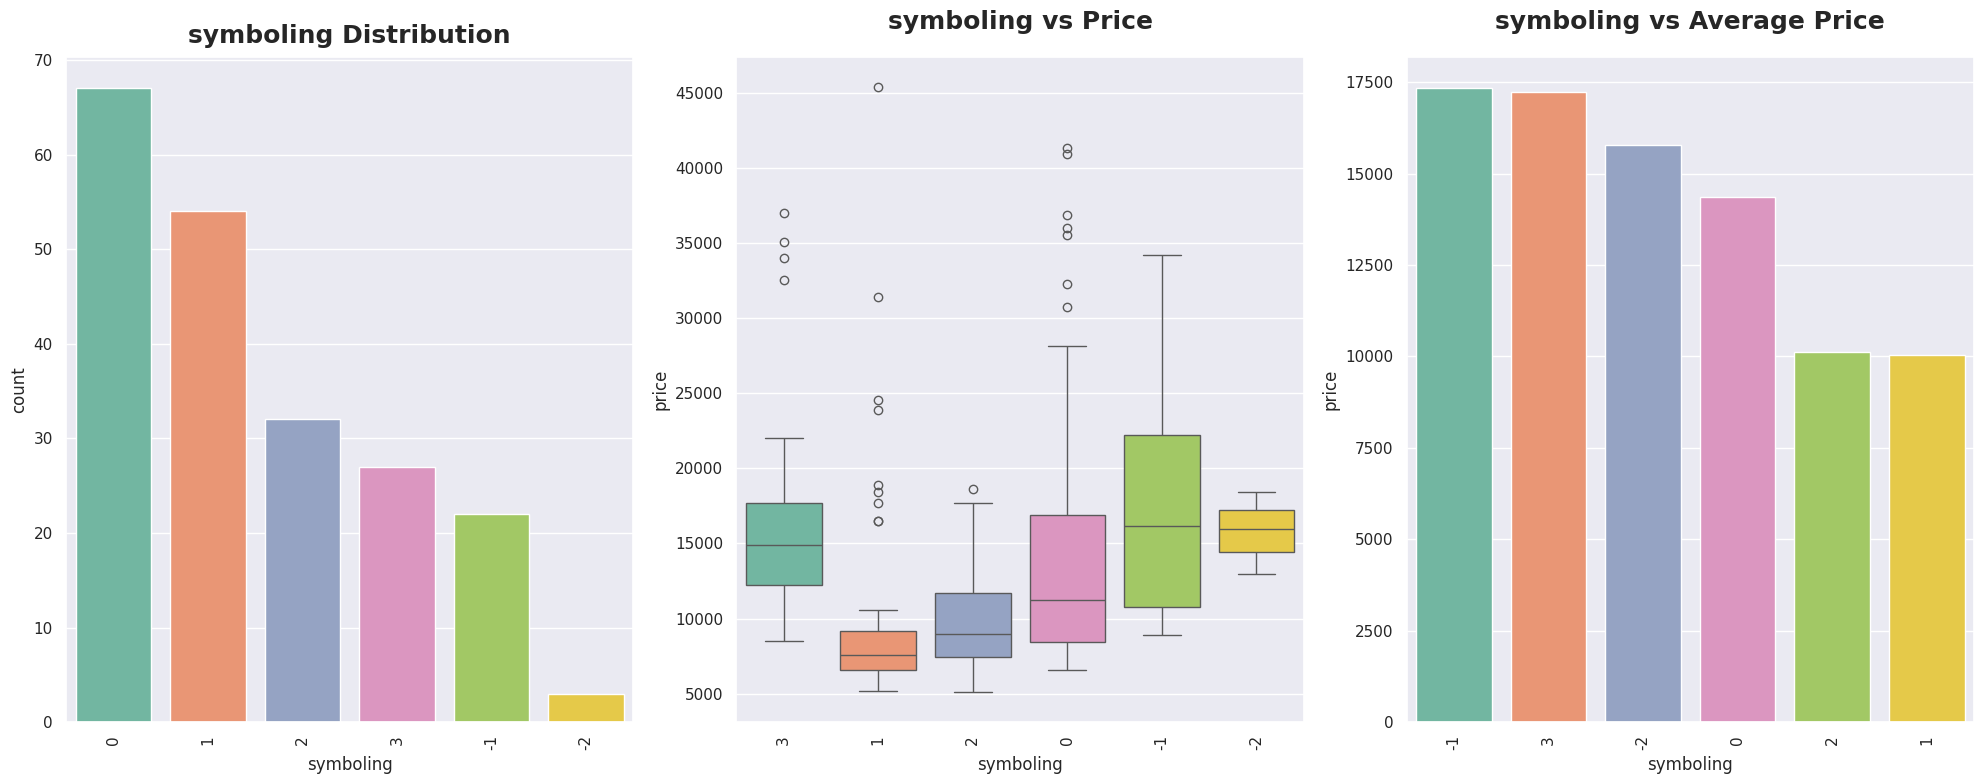

In [143]:
categorical_visualization("symboling")

### 2.12 Display the "CarLength", "CarWidth", "Carheight" features related to "Price".

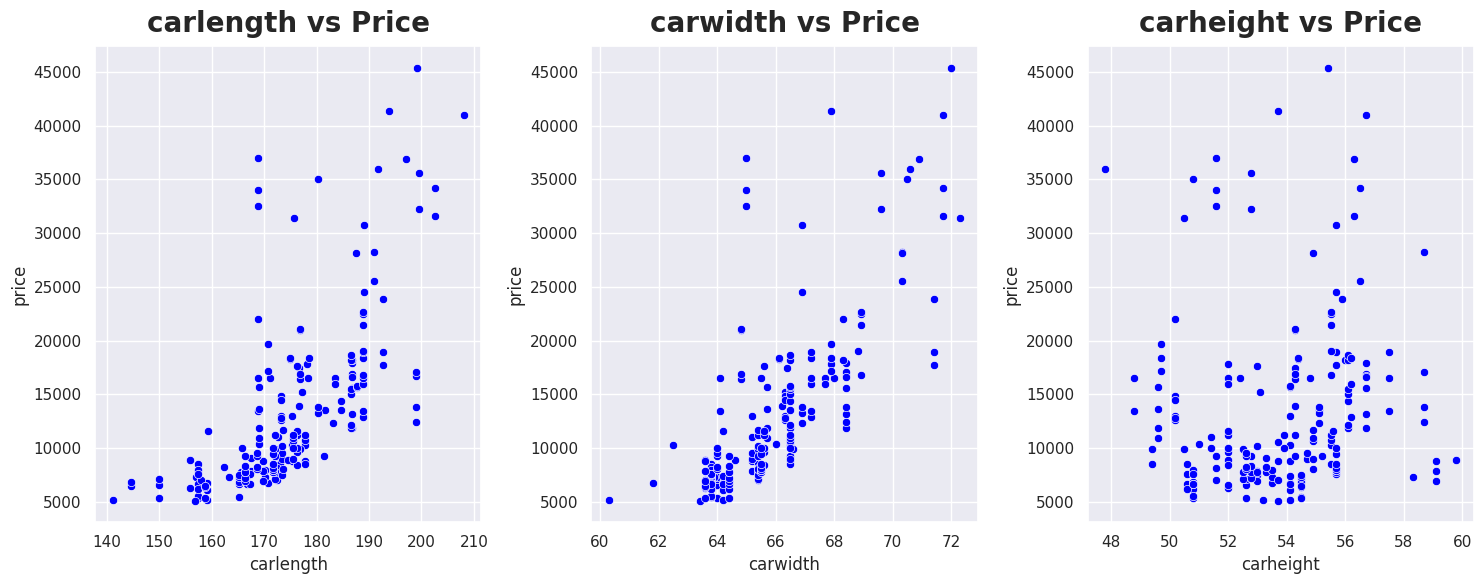

In [144]:
def scatter_plot(cols):
    x=1
    plt.figure(figsize=(15,6))
    for col in cols:
        plt.subplot(1,3,x)
        sns.scatterplot(x=col,y="price",data=df_pd,color="blue")
        plt.title(f"{col} vs Price",fontweight="black",fontsize=20,pad=10)
        plt.tight_layout()
        x+=1
    plt.show()


scatter_plot(["carlength","carwidth","carheight"])

### 2.13 Visualizing "EngineSize","Boreratio" & "Stroke" Features

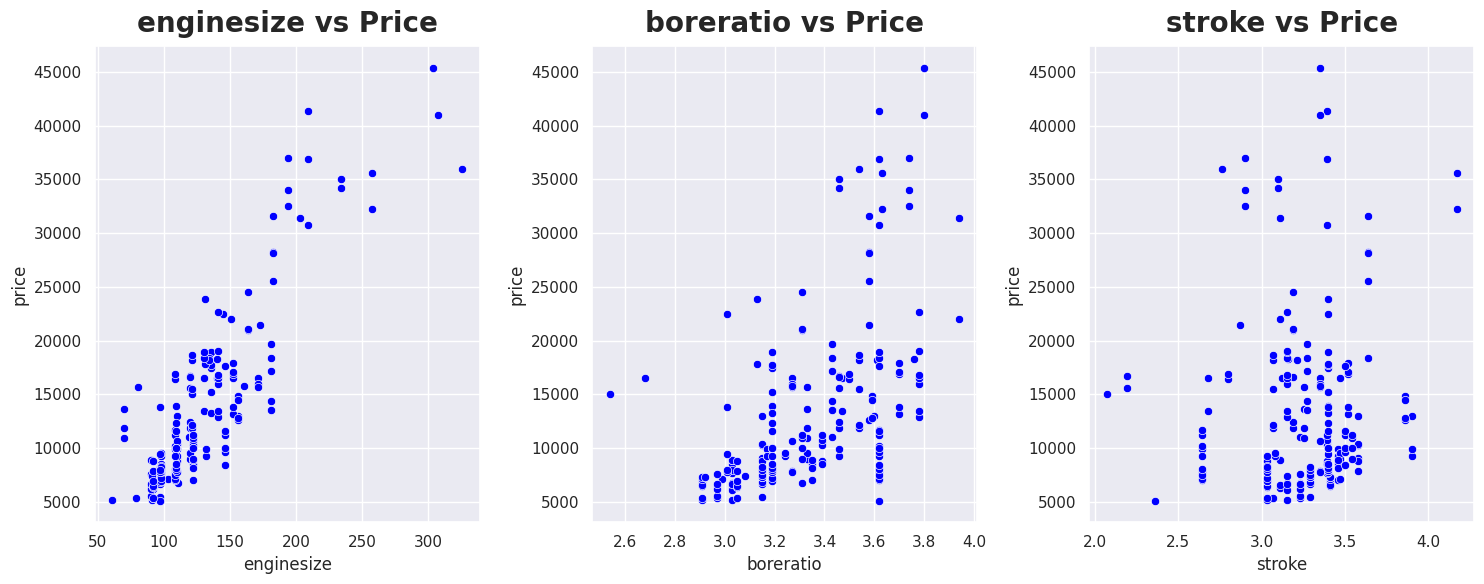

In [145]:
scatter_plot(["enginesize","boreratio","stroke"])


### 2.14 Visualizing "Compreessionratio","Horesepower" & "Peakrpm" Features

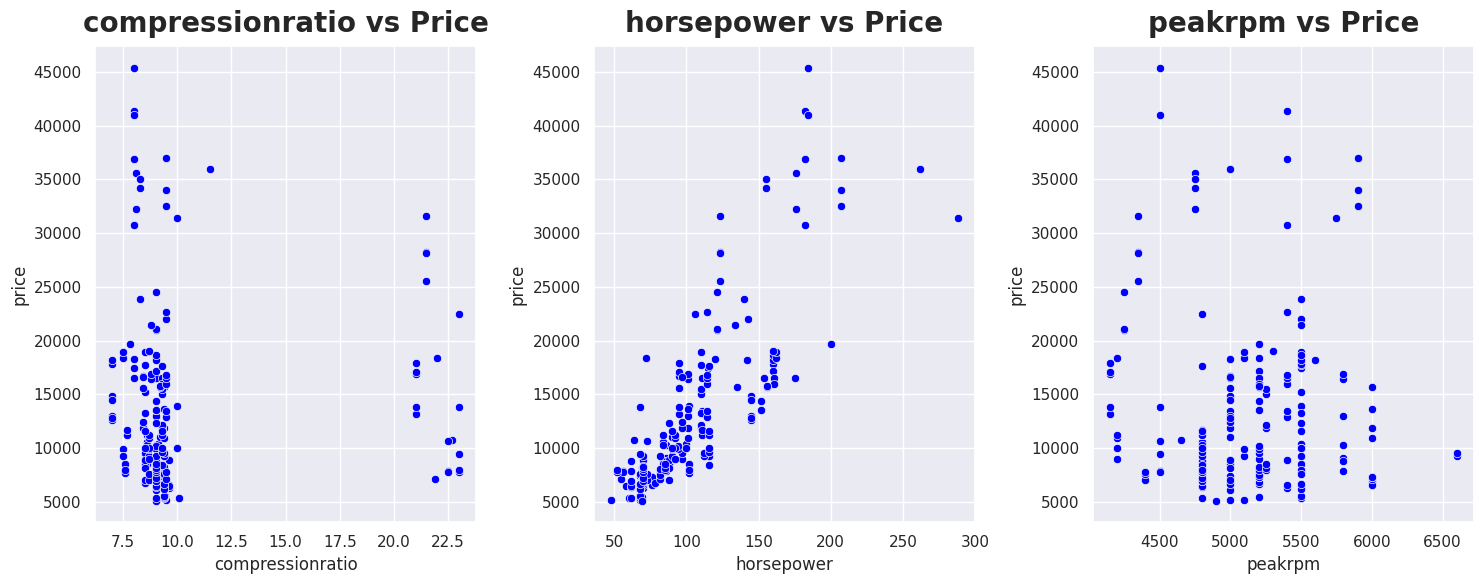

In [146]:
scatter_plot(["compressionratio","horsepower","peakrpm"])

### 2.15 Visualizing "WheelBase" & "Curbweight" Features

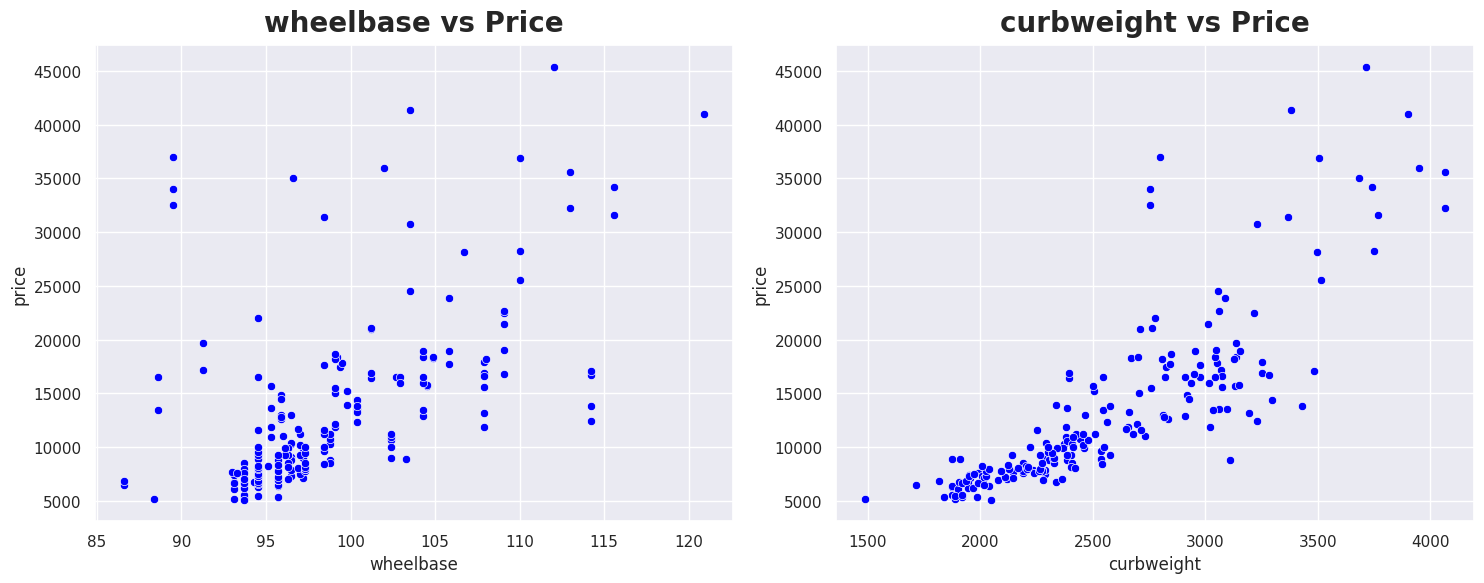

In [147]:
def scatter_plot(cols):
    x=1
    plt.figure(figsize=(15,6))
    for col in cols:
        plt.subplot(1,2,x)
        sns.scatterplot(x=col,y="price",data=df_pd,color="blue")
        plt.title(f"{col} vs Price",fontweight="black",fontsize=20,pad=10)
        plt.tight_layout()
        x+=1

scatter_plot(["wheelbase","curbweight"])

### 2.16 Visualizing "Citympg" & "Highwaympg" Features.

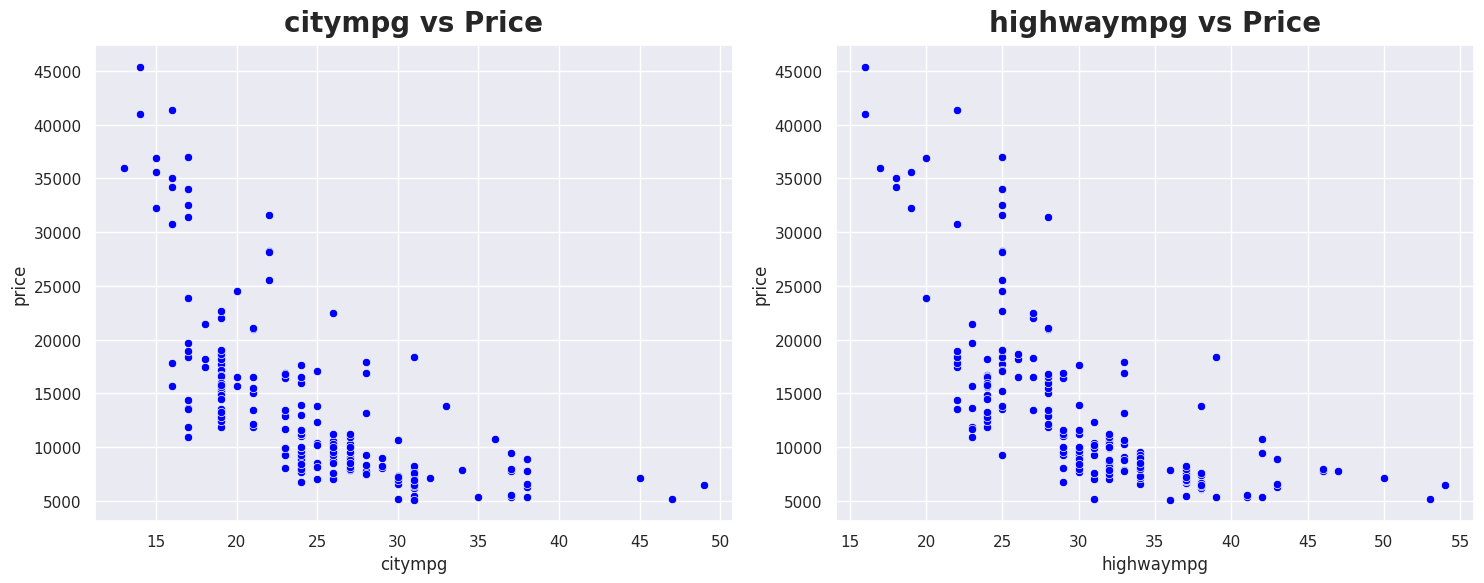

In [148]:
scatter_plot(["citympg","highwaympg"])

# Competitor research

+--------+-----+
|fueltype|count|
+--------+-----+
|     gas|  185|
|  diesel|   20|
+--------+-----+



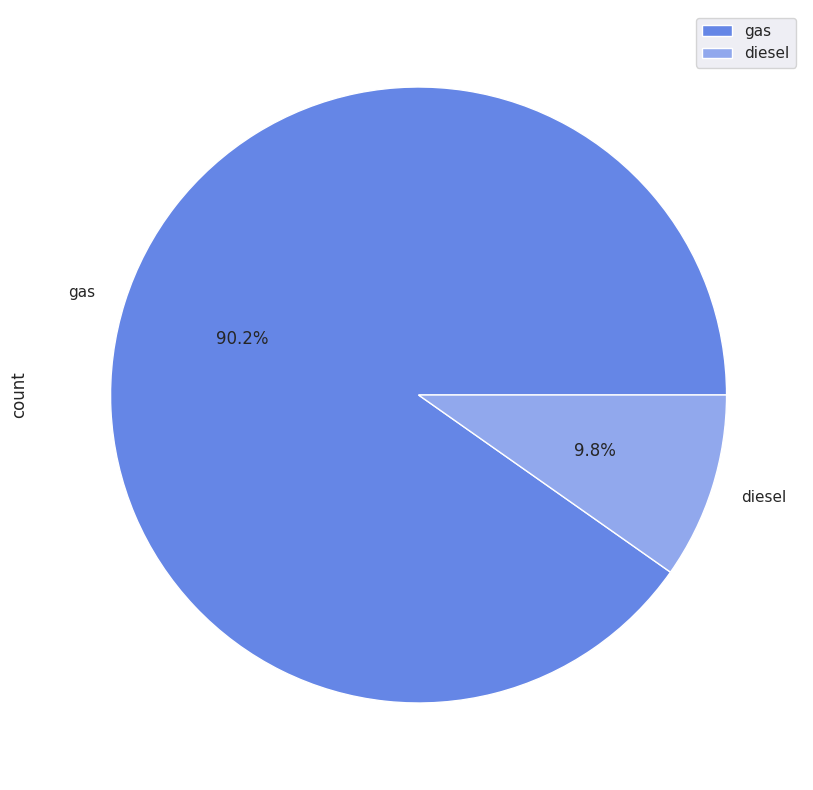

In [149]:
# Nhóm theo cột 'fueltype' và đếm số lần xuất hiện
df_count_fueltype= df.groupBy('fueltype').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_fueltype.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_fueltype = df_count_fueltype.toPandas()
df_pd_count_fueltype
plot = df_pd_count_fueltype.plot.pie(y='count', figsize=(10, 10), autopct='%1.1f%%', labels=df_pd_count_fueltype['fueltype'], colors=['#6586E6', '#91A8ED'])

+----------+-----+
|aspiration|count|
+----------+-----+
|       std|  168|
|     turbo|   37|
+----------+-----+



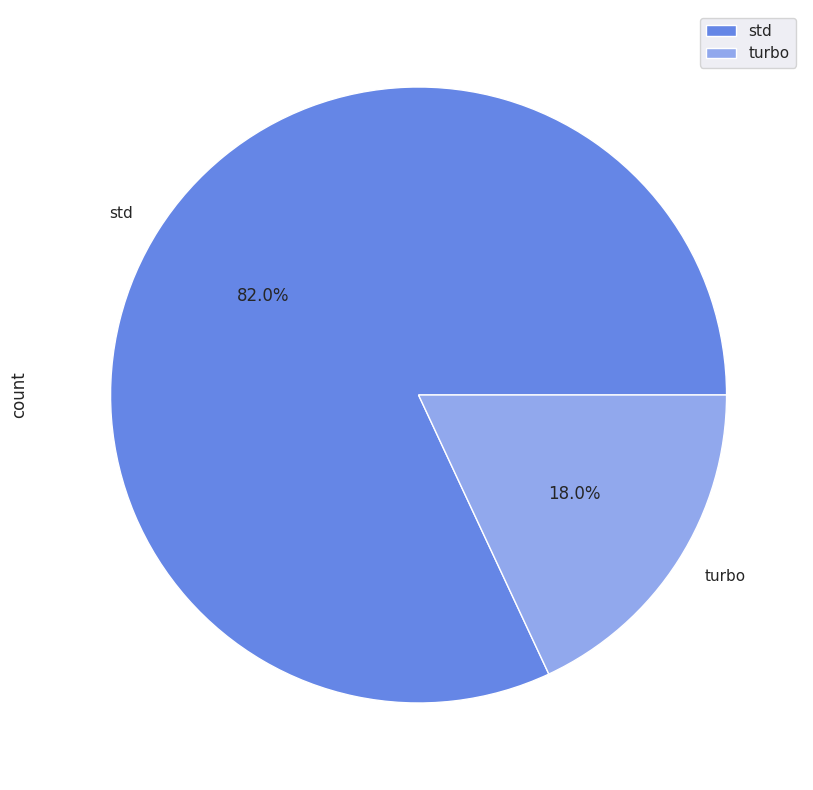

In [150]:
# Nhóm theo cột 'fueltype' và đếm số lần xuất hiện
df_count_aspiration= df.groupBy('aspiration').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_aspiration.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_aspiration = df_count_aspiration.toPandas()
df_pd_count_aspiration
plot = df_pd_count_aspiration.plot.pie(y='count', figsize=(10, 10), autopct='%1.1f%%', labels=df_pd_count_aspiration['aspiration'], colors=['#6586E6', '#91A8ED'])

+-----------+-----+
|    carbody|count|
+-----------+-----+
|      wagon|   25|
|convertible|    6|
|      sedan|   96|
|  hatchback|   70|
|    hardtop|    8|
+-----------+-----+



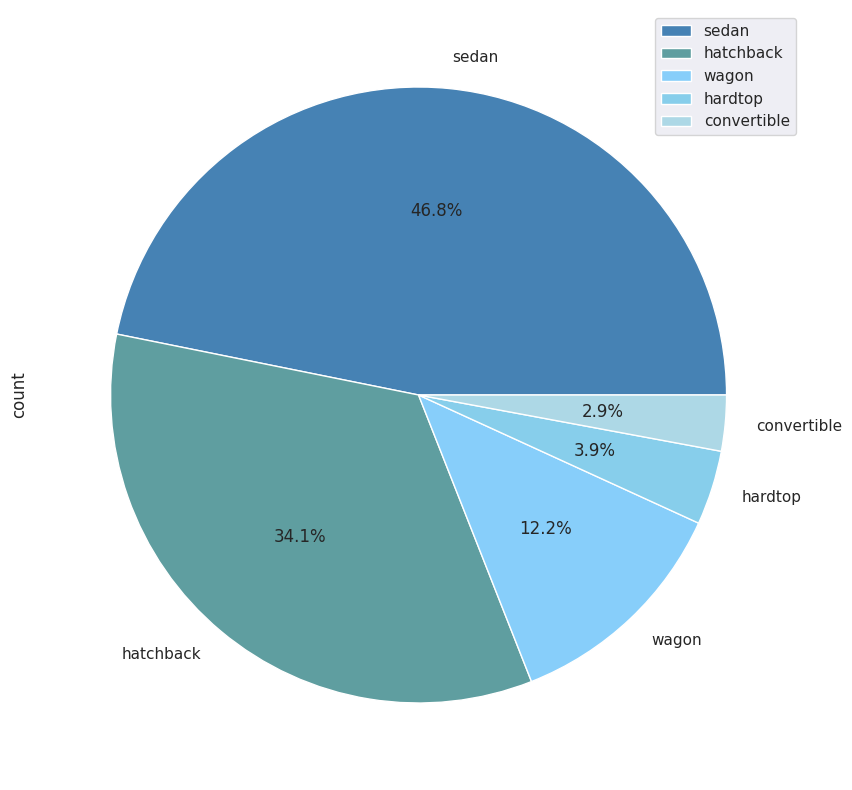

In [151]:
# Nhóm theo cột 'carbody' và đếm số lần xuất hiện
df_count_carbody= df.groupBy('carbody').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_carbody.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_carbody = df_count_carbody.toPandas()
df_pd_count_carbody = df_pd_count_carbody.sort_values(by='count', ascending=False)
df_pd_count_carbody
colors = ['#4682B4', '#5F9EA0', '#87CEFA', '#87CEEB', '#ADD8E6']
plot = df_pd_count_carbody.plot.pie(
    y='count',
    figsize=(10, 10),
    autopct='%1.1f%%',
    labels=df_pd_count_carbody['carbody'],
    colors=colors
)

+----------+-----+
|drivewheel|count|
+----------+-----+
|       fwd|  120|
|       rwd|   76|
|       4wd|    9|
+----------+-----+



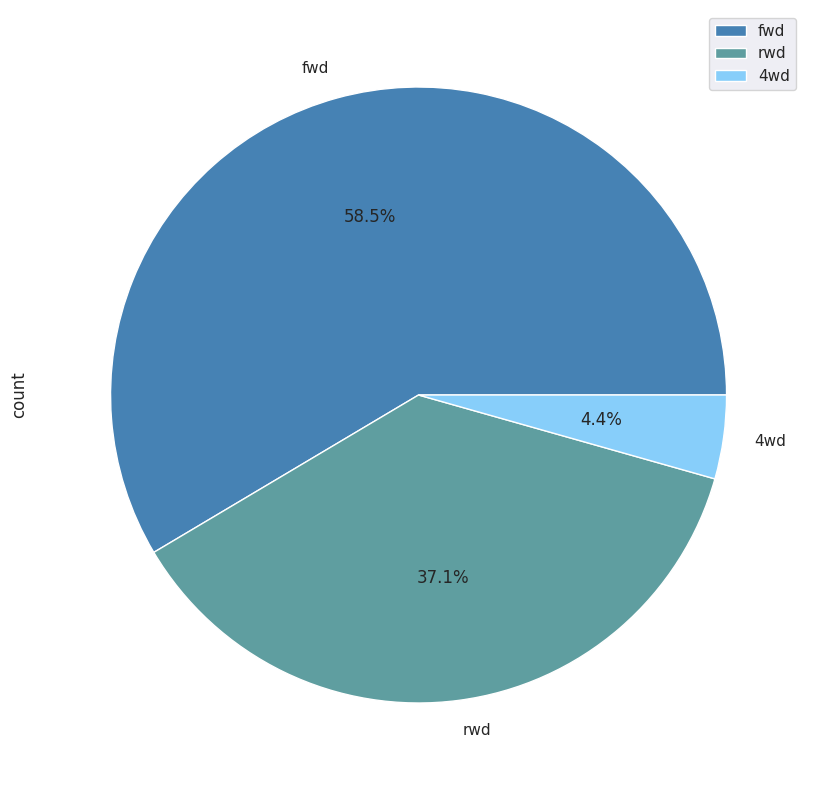

In [152]:
# Nhóm theo cột 'drivewheel' và đếm số lần xuất hiện
df_count_drivewheel= df.groupBy('drivewheel').agg(F.count('*').alias('count'))
# Hiển thị DataFrame kết quả
df_count_drivewheel.show()
# Chuyển DataFrame PySpark sang Pandas
df_pd_count_drivewheel = df_count_drivewheel.toPandas()
df_pd_count_drivewheel
colors = ['#4682B4', '#5F9EA0', '#87CEFA', '#87CEEB', '#ADD8E6']
plot = df_pd_count_drivewheel.plot.pie(
    y='count',
    figsize=(10, 10),
    autopct='%1.1f%%',
    labels=df_pd_count_drivewheel['drivewheel'],
    colors=colors
)

<Axes: xlabel='price', ylabel='Count'>

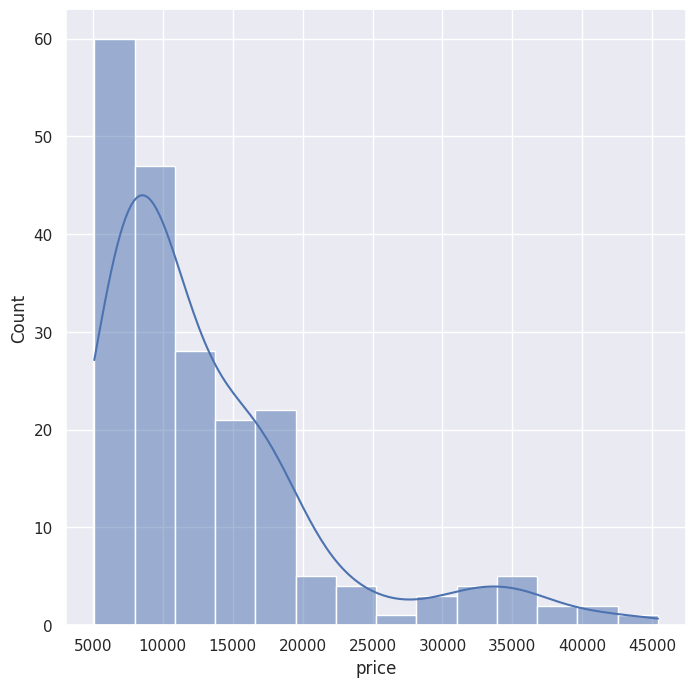

In [153]:
#sự phân bổ giá xe
sns.histplot(df_pd['price'],kde=True)

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


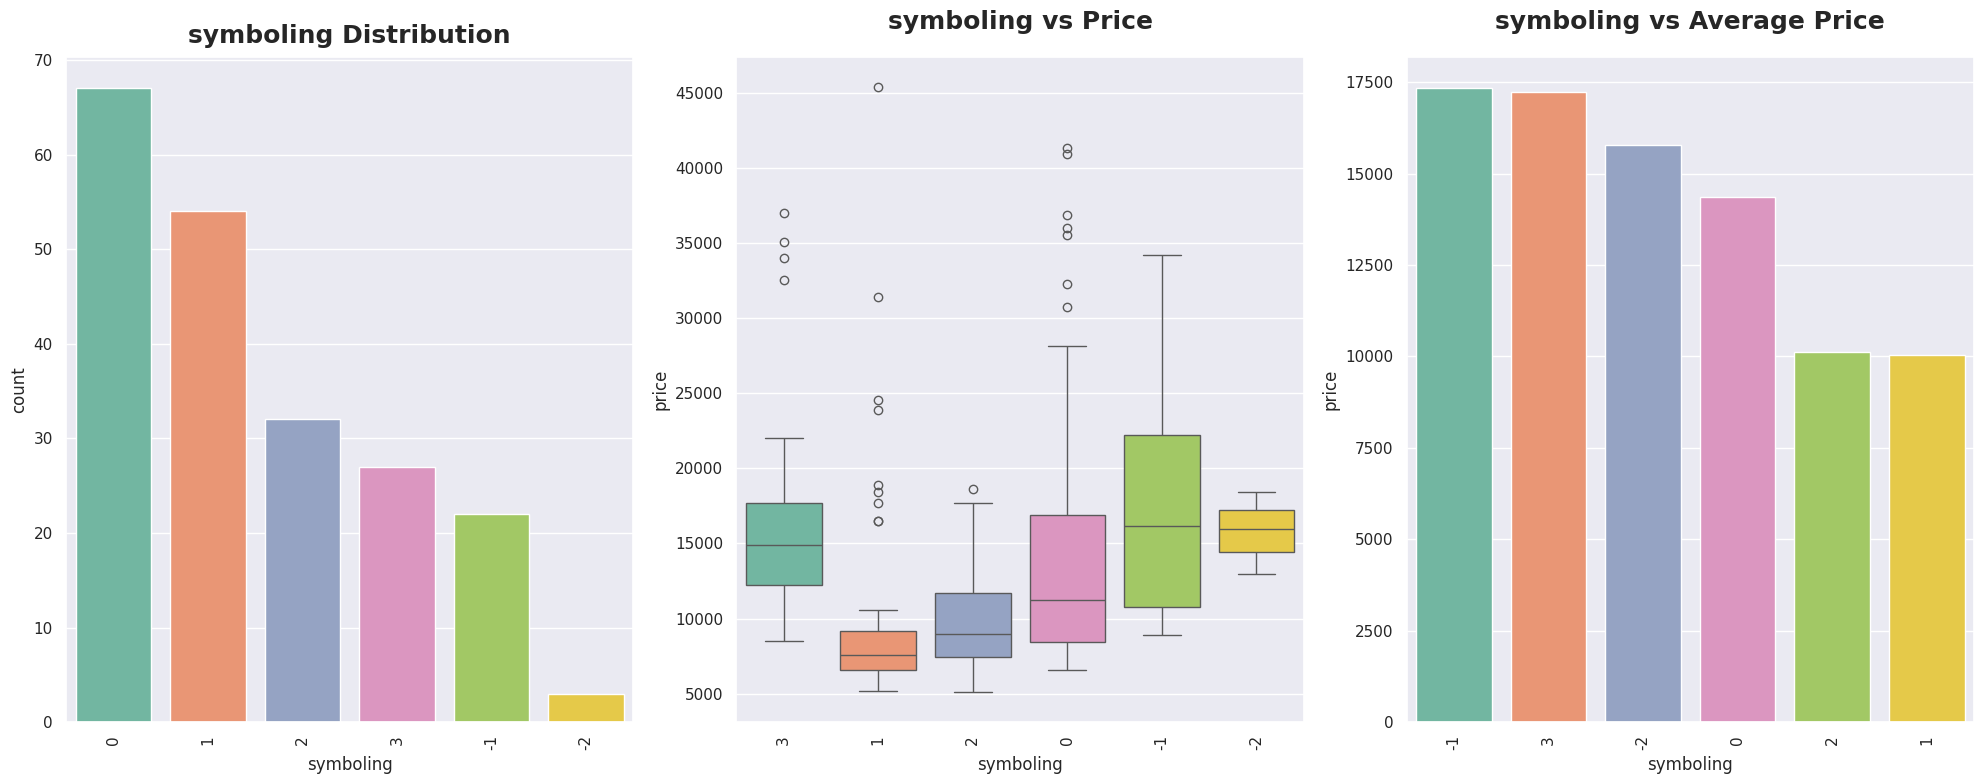

In [154]:
categorical_visualization("symboling")

<ipython-input-134-e8d5ff40702e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cols, data=df_pd, palette="Set2", order=df_pd[cols].value_counts().index)
<ipython-input-134-e8d5ff40702e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cols, y="price", data=df_pd, palette="Set2")
<ipython-input-134-e8d5ff40702e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y="price", data=x, palette="Set2")


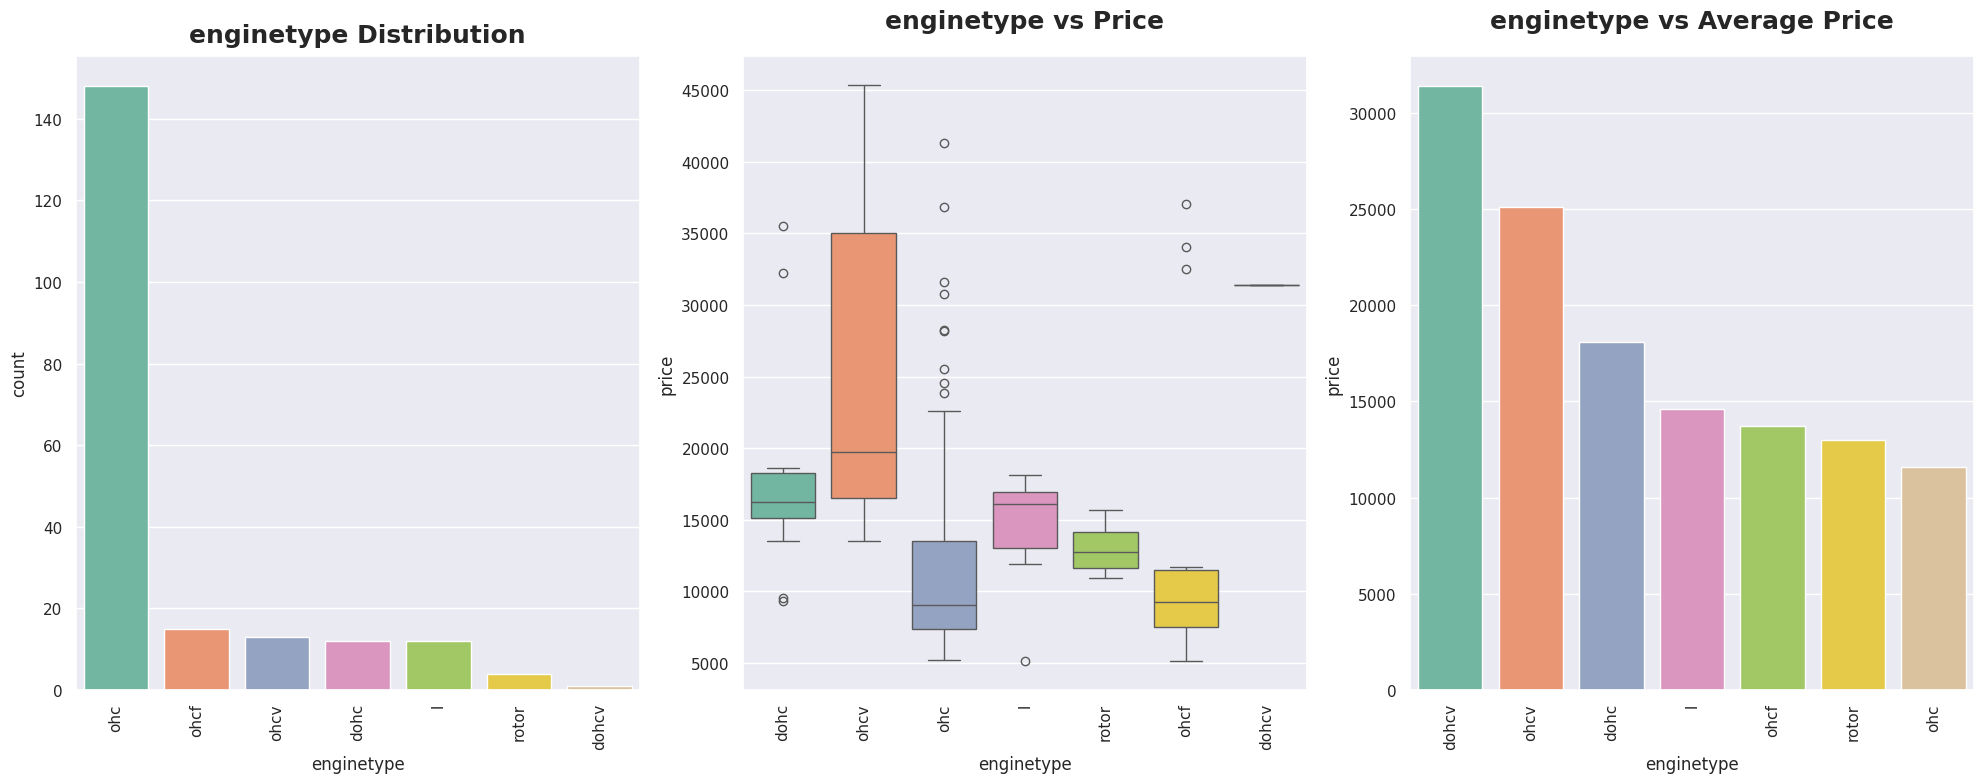

In [155]:
categorical_visualization("enginetype")

*note: The chart shows that car manufacturers are focusing on the fuel-efficient family car segment, with engines that are easy to repair and low cost.

# Factors Affecting Car Prices in the United States

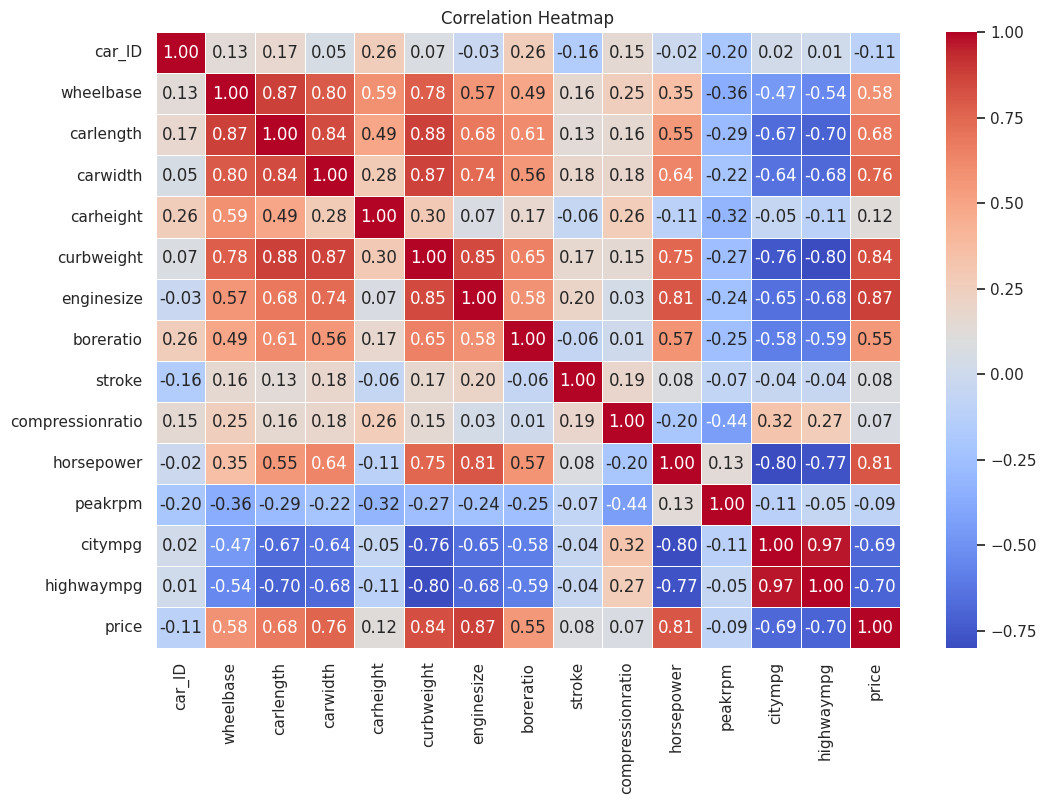

In [160]:
# Lựa chọn các cột kiểu số để tính toán tương quan
numeric_cols = df_pd.select_dtypes(include=['float64', 'int64']).columns

# Tính ma trận tương quan
corr_matrix = df_pd[numeric_cols].corr()

# Thiết lập kích thước cho biểu đồ
plt.figure(figsize=(12, 8))

# Vẽ biểu đồ nhiệt
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Hiển thị biểu đồ
plt.title('Correlation Heatmap')
plt.show()

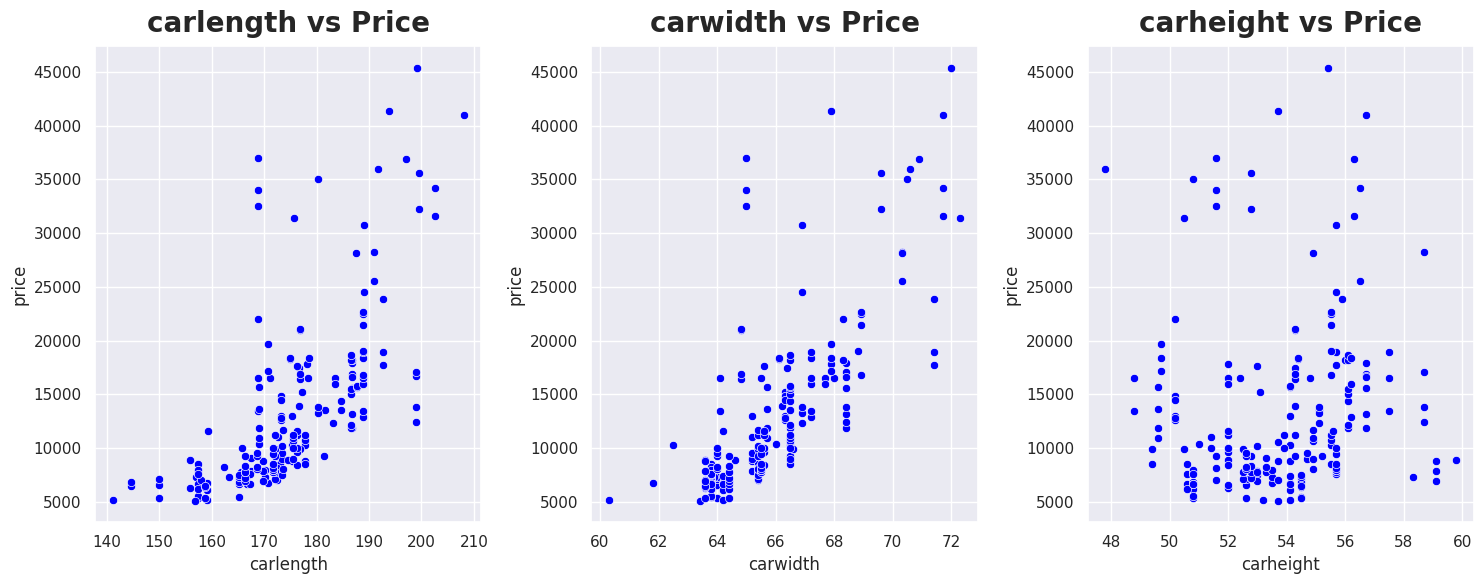

In [159]:
def scatter_plot(cols):
    x=1
    plt.figure(figsize=(15,6))
    for col in cols:
        plt.subplot(1,3,x)
        sns.scatterplot(x=col,y="price",data=df_pd,color="blue")
        plt.title(f"{col} vs Price",fontweight="black",fontsize=20,pad=10)
        plt.tight_layout()
        x+=1
    plt.show()


scatter_plot(["carlength","carwidth","carheight"])

Insights

We can clearly observe that carlength & carwidth features are highly correlated with the price feature.
So we can make an insight that with increment in length & width of the car there is an increment in price too.
From carlength vs price we can't make any inference as the data-points are too scattered.
Since CarHeight is not affecting Price We can drop this feature.

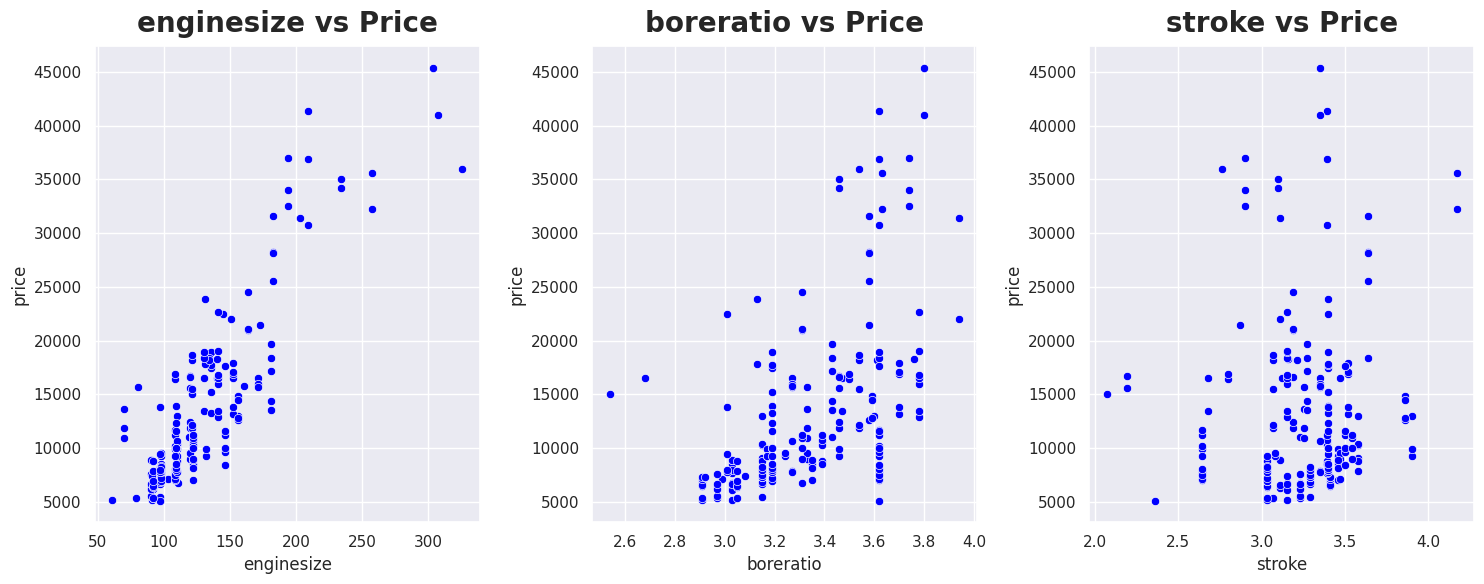

In [161]:
scatter_plot(["enginesize","boreratio","stroke"])

Insights

We can clearly observe that Enginesize is highly correlated with price feature. So we can say with the increment in enginesize the price of the cars increases.
From Boreratio vs Price we can observe that the feature is not highly correlated but still there's a correlation between the features. So we can say with increment in boreratio the price of cars increases.
From Stroke vs Price we can't make any inference as the data-points are too scattered.
Since Stroke is not affecting Price that much. We can drop this feature.

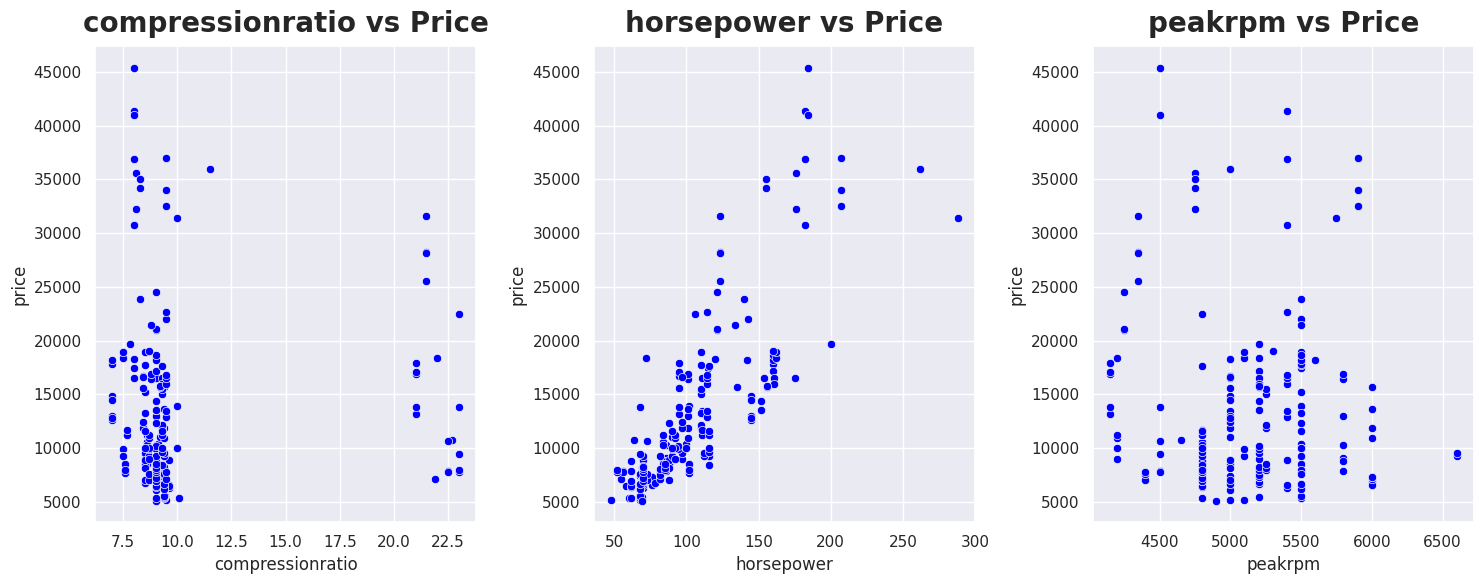

In [162]:
scatter_plot(["compressionratio","horsepower","peakrpm"])

Insights

We can clearly observe that Horsepower is highly correlated with Price. So we can say with the increment in Horsepower the price of cars also increases.
From Compressionratio vs Price & Peakrpm vs Price visuals we can't make any inference as the data-points are too scattered.
SInce Compressionratio & Peakrpm is not affecting price. So we can drop this features.

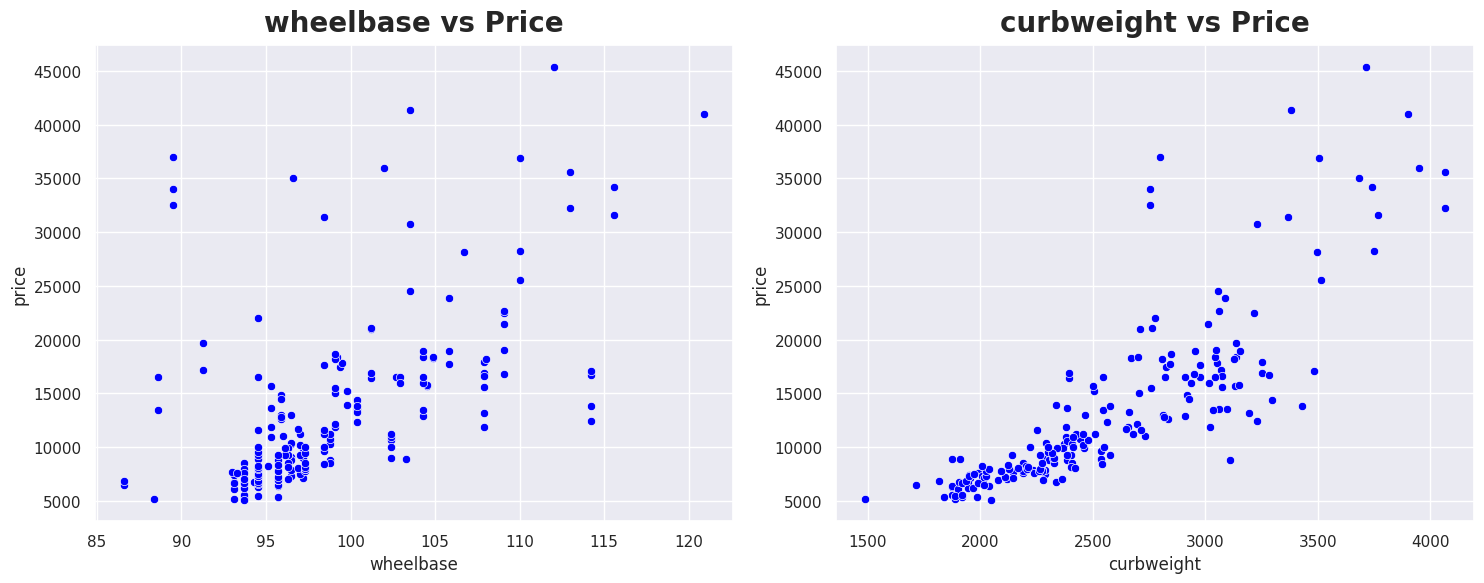

In [164]:
def scatter_plot(cols):
    x=1
    plt.figure(figsize=(15,6))
    for col in cols:
        plt.subplot(1,2,x)
        sns.scatterplot(x=col,y="price",data=df_pd,color="blue")
        plt.title(f"{col} vs Price",fontweight="black",fontsize=20,pad=10)
        plt.tight_layout()
        x+=1
scatter_plot(["wheelbase","curbweight"])

Insights

We can clearly observe that Curbweight is highly correlated with Price. So we can say with the increase in curbweight the price of cars increases.
From wheelbase vs price we can say that they are not highly correlated but still there's a correlation. So with wheel base the price of the cars also increases.

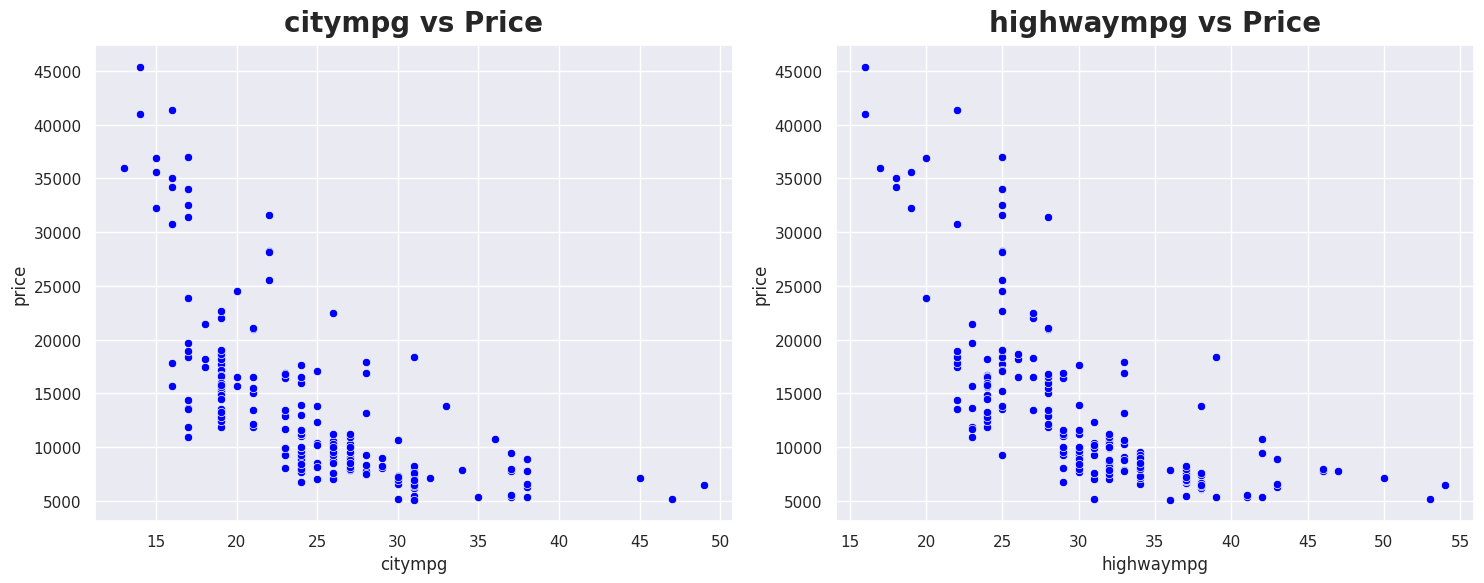

In [165]:
scatter_plot(["citympg","highwaympg"])

Insights

We can clearly observe that Citympg & Highwaympg are having negative correlation with the price.
So we can say that with the increment in citympg & Highwaympg the price of the cars decreases.
So our both Citympg & Highwaympg are useful features for price prediction.

# Preprocess data into the model

In [202]:
df_future_spark = df.select('wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg', 'price')
# cột ảnh hưởng tới giá
df_future = ['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg']
df_target = 'price'
print('Các đặc trưng (features): ', df_future)
print('Biến mục tiêu (target): ', df_target)

Các đặc trưng (features):  ['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg']
Biến mục tiêu (target):  price


## Feature Scaling of Numerical Data

In [203]:
# Xây dựng pipeline giúp tổ chức các bước tiền xử lý và mô hình hóa một cách tuần tự
# vector hóa đặc trưng
# Khởi tạo VectorAssembler
assembler = VectorAssembler(inputCols=df_future, outputCol="features_unscaled")
# các thuật toán học máy trong spark yêu cầu dữ liệu đầu vào ở định dạng vector -> VectorAssembler -> tạo ra 1 cột duy nhất chứa tất cả các đặc trưng
# Chuẩn hóa dữ liệu (Feature Scaling)
from pyspark.ml.feature import StandardScaler
# Khởi tạo StandardScaler
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=False)
# đảm bỏa tất cả các đặc trưng đều ở cùng 1 tỷ lệ
# chuẩn hóa đảm bảo không một đặc trưng nào chi phối mô hình hơn các đặc trưng khác.

In [204]:
# Tạo một pipeline với các bước tiền xử lý mô hình
# Pipline: VectorAssembler, StandardScaler: Chuẩn hóa dữ liệu đặc trưng
# LinearRegression: Thuật toán hồi quy tuyến tính
# Khởi tạo mô hình hồi quy tuyến tính
lr = LinearRegression(featuresCol='features', labelCol=df_target)

# Tạo pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [205]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_df, test_df = df_future_spark.randomSplit([0.7, 0.3], seed=42)

print(f"Số lượng mẫu huấn luyện: {train_df.count()}")
print(f"Số lượng mẫu kiểm tra: {test_df.count()}")

Số lượng mẫu huấn luyện: 140
Số lượng mẫu kiểm tra: 65


In [206]:
# Huấn luyện mô hình
pipeline_model = pipeline.fit(train_df)

In [207]:
# Xem thông tin mô hình đã huấn luyện
lr_model = pipeline_model.stages[-1]
print(f"Intercept: {lr_model.intercept}")
print(f"Coefficients: {lr_model.coefficients}")
# Hiển thị các hệ số riêng lẻ với tên đặc trưng
for feature, coef in zip(df_future, lr_model.coefficients):
    print(f"{feature}: {coef}")

Intercept: -40768.824180161944
Coefficients: [516.7185888434537,-334.62443460494944,1073.707719703746,1207.5266981414115,4390.88113489119,-308.33631928376127,1822.170507628358,-1263.415304609193,1134.6469458290946]
wheelbase: 516.7185888434537
carlength: -334.62443460494944
carwidth: 1073.707719703746
curbweight: 1207.5266981414115
enginesize: 4390.88113489119
boreratio: -308.33631928376127
horsepower: 1822.170507628358
citympg: -1263.415304609193
highwaympg: 1134.6469458290946


In [208]:
# đánh giá mô hình
# đánh giá hiệu suất của mô hình trên tập kiểm tra
# dự đoán trên tập kiểm tra
predictions = pipeline_model.transform(test_df)
# hiển thị một số dự đoán
predictions.select("prediction", df_target, "features").show(5)

+------------------+------+--------------------+
|        prediction| price|            features|
+------------------+------+--------------------+
|-754.1040826486278|5151.0|[13.6771211176165...|
| 5306.189457959037|5195.0|[14.4042983716075...|
| 6290.681495013036|6795.0|[14.4042983716075...|
| 6174.891994500038|6695.0|[14.4042983716075...|
| 6723.092103787683|7129.0|[14.4971295104148...|
+------------------+------+--------------------+
only showing top 5 rows



In [209]:
# dánh giá mô hình bằng các metric:
# RMSE(Root Mean Squared Error): đo lường độ lệch trung bình của dự đoán so với giá trị thực tế, nhạy cảm với các sai số lớn
# MAE (Mean Absolute Error): đo lường giá trị trung bình tuyệt đối của độ lệch, ít nhạy cảm hơn RMSE
# R2 (R-squared): Đo lường mức độ biến thiên của biến mục tiêu được giải thích bởi mô  hình. Giá trị càng gần 1 càng tốt
evaluator_rmse = RegressionEvaluator(labelCol=df_target, predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"RMSE = {rmse}")

evaluator_mae = RegressionEvaluator(labelCol=df_target, predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"MAE = {mae}")

evaluator_r2 = RegressionEvaluator(labelCol=df_target, predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"r2 = {r2}")

RMSE = 2827.5986422051533
MAE = 1917.1358330342493
r2 = 0.7440592262769061


In [214]:
# Hiển thị thông tin mô hình
lr_model = pipeline_model.stages[-1]
print(f"Intercept: {lr_model.intercept}")
print(f"Coefficients: {lr_model.coefficients}")

# Hiển thị các hệ số riêng lẻ với tên đặc trưng
for feature, coef in zip(df_future, lr_model.coefficients):
    print(f"{feature}: {coef}")

Intercept: -40768.824180161944
Coefficients: [516.7185888434537,-334.62443460494944,1073.707719703746,1207.5266981414115,4390.88113489119,-308.33631928376127,1822.170507628358,-1263.415304609193,1134.6469458290946]
wheelbase: 516.7185888434537
carlength: -334.62443460494944
carwidth: 1073.707719703746
curbweight: 1207.5266981414115
enginesize: 4390.88113489119
boreratio: -308.33631928376127
horsepower: 1822.170507628358
citympg: -1263.415304609193
highwaympg: 1134.6469458290946


In [215]:
# Tính ma trận tương quan giữa các đặc trưng
correlation_matrix = df_future_spark.select(df_future).toPandas().corr()
print(correlation_matrix)

            wheelbase  carlength  carwidth  curbweight  enginesize  boreratio  \
wheelbase    1.000000   0.874587  0.795144    0.776386    0.569329   0.488750   
carlength    0.874587   1.000000  0.841118    0.877728    0.683360   0.606454   
carwidth     0.795144   0.841118  1.000000    0.867032    0.735433   0.559150   
curbweight   0.776386   0.877728  0.867032    1.000000    0.850594   0.648480   
enginesize   0.569329   0.683360  0.735433    0.850594    1.000000   0.583774   
boreratio    0.488750   0.606454  0.559150    0.648480    0.583774   1.000000   
horsepower   0.353294   0.552623  0.640732    0.750739    0.809769   0.573677   
citympg     -0.470414  -0.670909 -0.642704   -0.757414   -0.653658  -0.584532   
highwaympg  -0.544082  -0.704662 -0.677218   -0.797465   -0.677470  -0.587012   

            horsepower   citympg  highwaympg  
wheelbase     0.353294 -0.470414   -0.544082  
carlength     0.552623 -0.670909   -0.704662  
carwidth      0.640732 -0.642704   -0.677218  
c

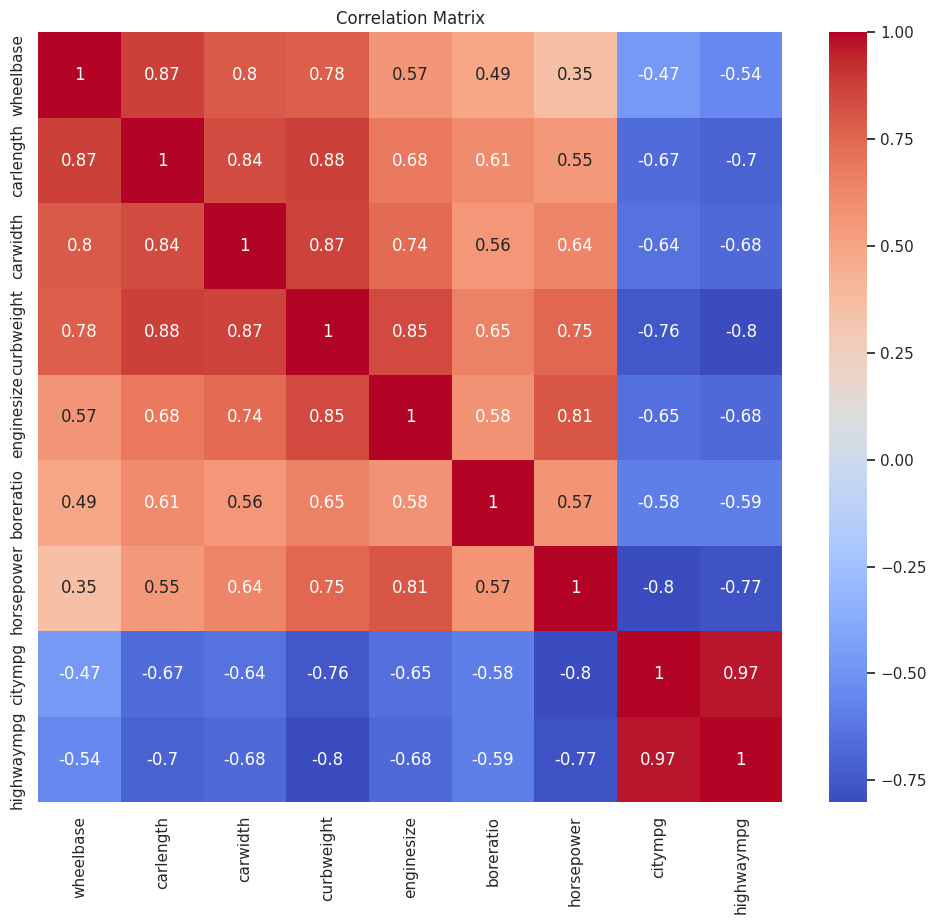

In [216]:
# Hiển thị ma trận tương quan
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()